In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder # No longer needed for this approach
import shap  # Make sure SHAP is installed: pip install shap
import traceback  # For detailed error printing
import warnings  # To suppress potential warnings if desired
#import xgboost as xgb
# Optional: Suppress SHAP UserWarnings
warnings.filterwarnings('ignore', category=UserWarning, module='shap')
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
# --- Database Connection Details ---
# !!! IMPORTANT: Replace with your actual credentials or use a secure method !!!
# Consider environment variables or a config file instead of hardcoding
server_name = '10.10.9.32'
database_name = 'TLMAL'
user_id = 'taslview'
password = 'New@1234'  # This is insecure - manage secrets properly!
# Ensure this driver is installed and matches your system (e.g., '{ODBC Driver 17 for SQL Server}')
driver = '{SQL Server}'

# --- Database Connection ---
try:
    # F-string requires Python 3.6+
    connection_string = f"Driver={driver};Server={server_name};Database={database_name};UID={user_id};PWD={password}"
    conn = pyodbc.connect(connection_string)
    print("Database connection successful.")
except Exception as e:
    print(f"Database connection failed: {e}")
    print("Please ensure the SQL Server is running, credentials are correct,")
    print("the specified ODBC driver is installed, and network connectivity is okay.")
    # Exit or handle error appropriately if connection fails
    exit()

# --- SQL Query to Fetch Data ---
Power = '''SELECT Distinct [Time-Hourly]
      ,[Name]
      ,[Active_Energy_Delivered]
      ,[Operating_Hours]
      ,[Average_Voltage_Line_to_Neutral]
      ,[Average_Voltage_Line_to_Line]
      ,[Jumbo_Humidity3]
      ,[Jumbo_Temp2]
      ,[Jumbo_Temp1]
      ,[Jumbo_Temp3]
      ,[Jumbo_Humidity]
      ,[T2M]
      ,[Date_Time]
      ,[Avg_Return_Water_Temp]
      ,[Avg_Supply_water_Temp]
      ,[TimeStamp]
      ,[Year]
      ,[Month]
      ,[Day]
      ,[hour]
      ,[Date]
      ,[Start Date]
      ,[1st_Shift]
      ,[2nd_Shift]
      ,[3rd_Shift]
      ,[common]
      ,[General]
      ,[Left_Right_Name]
      ,[Score]
      ,[Right_Date_Time]
      ,[Right_3rd_Shift]
      ,[Result]
  FROM [TLMAL].[dbo].[HVAC_Regression]'''  # Consider adding WHERE clauses here if possible to reduce data fetched

try:
    print("Fetching data from database...")
    data1 = pd.read_sql(Power, conn)
    conn.close()  # Close connection immediately after fetching data
    print("Data fetched successfully.")
    # Optional: Save raw data
    # data.to_excel("raw_hvac_data.xlsx", index=False)
except Exception as e:
    print(f"Failed to fetch data: {e}")
    traceback.print_exc()  # Print full traceback for SQL errors
    exit()

Database connection successful.
Fetching data from database...


C:\Users\srampur\AppData\Local\Temp\ipykernel_17372\1864561575.py:61: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data1 = pd.read_sql(Power, conn)


Data fetched successfully.


In [3]:
data=data1
data.to_excel("E:/HVAC/Hvac_data.xlsx",index=False)

In [4]:
print("Initial data shape:", data.shape)
print("Initial columns:", data.columns.tolist())
print("Initial data types:\n", data.dtypes)  # Check initial types

Initial data shape: (312565, 32)
Initial columns: ['Time-Hourly', 'Name', 'Active_Energy_Delivered', 'Operating_Hours', 'Average_Voltage_Line_to_Neutral', 'Average_Voltage_Line_to_Line', 'Jumbo_Humidity3', 'Jumbo_Temp2', 'Jumbo_Temp1', 'Jumbo_Temp3', 'Jumbo_Humidity', 'T2M', 'Date_Time', 'Avg_Return_Water_Temp', 'Avg_Supply_water_Temp', 'TimeStamp', 'Year', 'Month', 'Day', 'hour', 'Date', 'Start Date', '1st_Shift', '2nd_Shift', '3rd_Shift', 'common', 'General', 'Left_Right_Name', 'Score', 'Right_Date_Time', 'Right_3rd_Shift', 'Result']
Initial data types:
 Time-Hourly                                object
Name                                       object
Active_Energy_Delivered                   float64
Operating_Hours                           float64
Average_Voltage_Line_to_Neutral           float64
Average_Voltage_Line_to_Line              float64
Jumbo_Humidity3                           float64
Jumbo_Temp2                               float64
Jumbo_Temp1                          

In [5]:
# --- Data Preprocessing ---
print("\nStarting Data Preprocessing...")
print("First, we will look on HVAC(Chiller)")
# Rename inconsistent names
if 'Name' in data.columns:
    data['Name'] = data['Name'].replace('AHU1.1', 'AHU.1')
    # Filter for relevant names (Still useful to filter rows, even if 'Name' isn't used as a feature)
    data = data[data['Name'].str.contains('HVAC', na=False)]
    print(f"Shape after filtering Name: {data.shape}")
else:
    print("Warning: 'Name' column not found for filtering.")


# Filter target variable range
if 'Active_Energy_Delivered' in data.columns:
    # Ensure target is numeric before filtering
    data['Active_Energy_Delivered'] = pd.to_numeric(
        data['Active_Energy_Delivered'], errors='coerce')
    # Drop rows where conversion failed
    data.dropna(subset=['Active_Energy_Delivered'], inplace=True)
    data = data[(data['Active_Energy_Delivered'] >= 0) &
                (data['Active_Energy_Delivered'] < 120)]  # Adjust upper limit if needed
    print(f"Shape after filtering Active_Energy_Delivered: {data.shape}")
else:
    print("Error: Target column 'Active_Energy_Delivered' not found. Exiting.")
    exit()


Starting Data Preprocessing...
First, we will look on HVAC(Chiller)
Shape after filtering Name: (107638, 32)
Shape after filtering Active_Energy_Delivered: (96614, 32)


C:\Users\srampur\AppData\Local\Temp\ipykernel_17372\1213712933.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Active_Energy_Delivered'] = pd.to_numeric(
C:\Users\srampur\AppData\Local\Temp\ipykernel_17372\1213712933.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['Active_Energy_Delivered'], inplace=True)


In [6]:
set(data['Name'])

{'HVAC.Chiller_1',
 'HVAC.Chiller_2',
 'HVAC.Chiller_3',
 'HVAC.PrimaryPump_1',
 'HVAC.PrimaryPump_2',
 'HVAC.Primarypump_3',
 'HVAC.Primarypump_4',
 'HVAC.SecondaryPump'}

In [7]:
# Convert Date and handle errors
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    initial_rows = data.shape[0]
    data = data.dropna(subset=['Date'])
    print(f"Dropped {initial_rows - data.shape[0]} rows due to invalid Date format.")
    print(f"Shape after handling Date: {data.shape}")
    data = data.sort_values(by='Date')
else:
    print("Error: 'Date' column not found for train/test split. Exiting.")
    exit()

Dropped 0 rows due to invalid Date format.
Shape after handling Date: (96614, 32)


In [8]:
# Impute Jumbo Temperature and Humidity (Check column existence first)
temp_cols_exist = all(col in data.columns for col in ['Jumbo_Temp1', 'Jumbo_Temp2', 'Jumbo_Temp3'])
humidity_cols_exist = all(col in data.columns for col in ['Jumbo_Humidity', 'Jumbo_Humidity3'])

if temp_cols_exist:
    print("Imputing Jumbo Temperatures...")
    # Convert to numeric first
    for col in ['Jumbo_Temp1', 'Jumbo_Temp2', 'Jumbo_Temp3']:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data['Jumbo_Temp1'] = data['Jumbo_Temp1'].fillna(data['Jumbo_Temp2']).fillna(data['Jumbo_Temp3'])
else:
    print("Warning: One or more Jumbo Temperature columns missing, skipping imputation.")

if humidity_cols_exist:
    print("Imputing Jumbo Humidity...")
    # Convert to numeric first
    for col in ['Jumbo_Humidity', 'Jumbo_Humidity3']:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data['Jumbo_Humidity'] = data['Jumbo_Humidity'].fillna(data['Jumbo_Humidity3'])
else:
    print("Warning: One or more Jumbo Humidity columns missing, skipping imputation.")

# Drop redundant columns if they exist AND imputation was attempted
cols_to_drop = []
if temp_cols_exist:
    cols_to_drop.extend(['Jumbo_Temp2', 'Jumbo_Temp3'])
if humidity_cols_exist:
    cols_to_drop.append('Jumbo_Humidity3')

data.drop(columns=[col for col in cols_to_drop if col in data.columns], inplace=True)
print(f"Dropped redundant columns: {[col for col in cols_to_drop if col in data.columns]}")


# Forward/Backward fill remaining NaNs for imputed columns
if 'Jumbo_Temp1' in data.columns:
    initial_nan = data['Jumbo_Temp1'].isna().sum()
    data['Jumbo_Temp1'] = data['Jumbo_Temp1'].ffill().bfill()
    print(f"Filled {initial_nan - data['Jumbo_Temp1'].isna().sum()} NaNs in Jumbo_Temp1.")
if 'Jumbo_Humidity' in data.columns:
    initial_nan = data['Jumbo_Humidity'].isna().sum()
    data['Jumbo_Humidity'] = data['Jumbo_Humidity'].ffill().bfill()
    print(f"Filled {initial_nan - data['Jumbo_Humidity'].isna().sum()} NaNs in Jumbo_Humidity.")

# Filter based on T2M and Operating_Hours (Check column existence and convert to numeric)
if 'T2M' in data.columns:
   data = data[(data['T2M'] > 0) & (data['T2M'] < 50)]
   print(f"Shape after filtering T2M: {data.shape}")
if 'Operating_Hours' in data.columns:
   data = data[(data['Operating_Hours'] > 0) &
               (data['Operating_Hours'] < 1.1)]
   print(f"Shape after filtering Operating_Hours: {data.shape}")
else:
    print("Warning: 'Operating_Hours' column not found for filtering.")

Imputing Jumbo Temperatures...
Imputing Jumbo Humidity...
Dropped redundant columns: []
Filled 212 NaNs in Jumbo_Temp1.
Filled 212 NaNs in Jumbo_Humidity.
Shape after filtering T2M: (92151, 29)
Shape after filtering Operating_Hours: (18660, 29)


In [9]:
data.shape

(18660, 29)

In [10]:
# Create Compressor_delta (Check column existence)
if 'Avg_Return_Water_Temp' in data.columns and 'Avg_Supply_water_Temp' in data.columns:
   # Ensure columns are numeric before subtraction
   data['Avg_Return_Water_Temp'] = pd.to_numeric(data['Avg_Return_Water_Temp'], errors='coerce')
   data['Avg_Supply_water_Temp'] = pd.to_numeric(data['Avg_Supply_water_Temp'], errors='coerce')
   data['Compressor_delta'] = data['Avg_Return_Water_Temp'] - data['Avg_Supply_water_Temp']
   print("Compressor_delta created.")

Compressor_delta created.


In [11]:
data.columns

Index(['Time-Hourly', 'Name', 'Active_Energy_Delivered', 'Operating_Hours',
       'Average_Voltage_Line_to_Neutral', 'Average_Voltage_Line_to_Line',
       'Jumbo_Temp1', 'Jumbo_Humidity', 'T2M', 'Date_Time',
       'Avg_Return_Water_Temp', 'Avg_Supply_water_Temp', 'TimeStamp', 'Year',
       'Month', 'Day', 'hour', 'Date', 'Start Date', '1st_Shift', '2nd_Shift',
       '3rd_Shift', 'common', 'General', 'Left_Right_Name', 'Score',
       'Right_Date_Time', 'Right_3rd_Shift', 'Result', 'Compressor_delta'],
      dtype='object')

In [12]:
data.isnull().sum()

Time-Hourly                            0
Name                                   0
Active_Energy_Delivered                0
Operating_Hours                        0
Average_Voltage_Line_to_Neutral        0
Average_Voltage_Line_to_Line           0
Jumbo_Temp1                            0
Jumbo_Humidity                         0
T2M                                    0
Date_Time                          18660
Avg_Return_Water_Temp              18193
Avg_Supply_water_Temp              18193
TimeStamp                              0
Year                                   0
Month                                  0
Day                                    0
hour                                   0
Date                                   0
Start Date                          9653
1st_Shift                          10391
2nd_Shift                          10220
3rd_Shift                          18423
common                             18099
General                             9812
Left_Right_Name 

In [13]:
final_columns = [
   'Name', 'T2M', 'Operating_Hours', 'Active_Energy_Delivered','Jumbo_Temp1','Jumbo_Humidity','Average_Voltage_Line_to_Line',
   'Year', 'Month', 'Day', 'Date', 'hour', 'Avg_Supply_water_Temp','Current_Phase_Average', 'Average_Voltage_Line_to_Neutral',
   'Avg_Return_Water_Temp', 'Compressor_delta', '1st_Shift', '2nd_Shift', 'common', 'General'
]

In [14]:
# Keep only columns that actually exist in the dataframe
available_final_columns = [col for col in final_columns if col in data.columns]
print(f"\nUsing available columns for processing: {available_final_columns}")
# Ensure columns selected actually exist after potential drops/creation
available_final_columns = [col for col in available_final_columns if col in data.columns]
data = data[available_final_columns]


Using available columns for processing: ['Name', 'T2M', 'Operating_Hours', 'Active_Energy_Delivered', 'Jumbo_Temp1', 'Jumbo_Humidity', 'Average_Voltage_Line_to_Line', 'Year', 'Month', 'Day', 'Date', 'hour', 'Avg_Supply_water_Temp', 'Average_Voltage_Line_to_Neutral', 'Avg_Return_Water_Temp', 'Compressor_delta', '1st_Shift', '2nd_Shift', 'common', 'General']


In [15]:
data=data.fillna(0)
data.to_excel("E:/HVAC/preprocessed_data.xlsx", index=False)

In [17]:
df=data
df.shape    #18233

(18660, 20)

Loading and preparing data from single file...
Full dataset shape: (18660, 20)
Using data up to 2025-11-03 as 'today'.
Training data shape: (17590, 20) (Data before 2025-10-04)
Test data shape: (1070, 20) (Data from 2025-10-04 onwards)

Applying One-Hot Encoding to 'Name'...
New encoded features: ['Name_HVAC.Chiller_1', 'Name_HVAC.Chiller_2', 'Name_HVAC.Chiller_3', 'Name_HVAC.PrimaryPump_1', 'Name_HVAC.PrimaryPump_2', 'Name_HVAC.Primarypump_3', 'Name_HVAC.SecondaryPump']
X_train shape: (17590, 24)
X_test shape: (1070, 24)

--- Objective 4: Correlation Analysis (on Training Data) ---
Correlation with 'Active_Energy_Delivered':
Active_Energy_Delivered            1.000000
Avg_Supply_water_Temp              0.346958
Avg_Return_Water_Temp              0.345542
Compressor_delta                   0.159566
Average_Voltage_Line_to_Line       0.105398
Average_Voltage_Line_to_Neutral    0.103619
Year                               0.071383
Operating_Hours                    0.067510
hour          

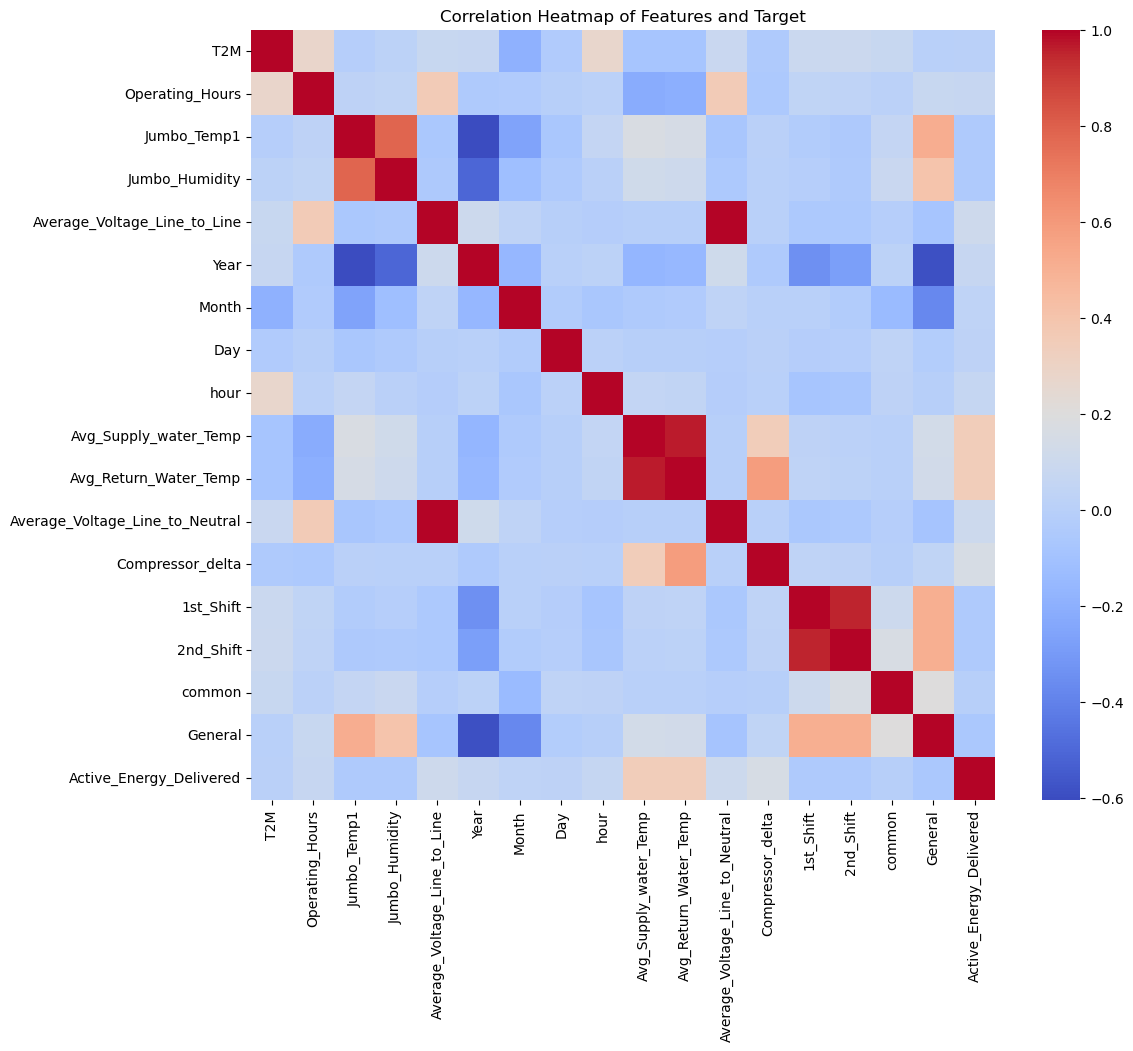


--- Objectives 1, 2 & 5: Training, Evaluation, and Prediction ---
Training Random Forest on all 17590 training samples...
Calculating evaluation metrics...
--- Global Model Metrics ---
  Train: RMSE=4.66, MSE=21.67, R²=0.95
  Test:  RMSE=8.54, MSE=72.88, R²=0.92
  OOB Score (Out-of-Bag): 0.9184

--- Objective 5: Predictions for Recent Data (Test Set) ---
Sample of predictions vs. actuals for the test period:
                     Name        T2M  Operating_Hours  Actual_Power_Consumption  Jumbo_Temp1  Jumbo_Humidity  Average_Voltage_Line_to_Line  Year  Month  Day       Date  hour  Avg_Supply_water_Temp  Average_Voltage_Line_to_Neutral  Avg_Return_Water_Temp  Compressor_delta  1st_Shift  2nd_Shift  common  General  Predicted_Power_Consumption
17590  HVAC.PrimaryPump_1  21.791667         0.596111                     4.299          0.0             0.0                   1662.497833    25     10    4 2025-10-04     7                    0.0                       959.856613                   

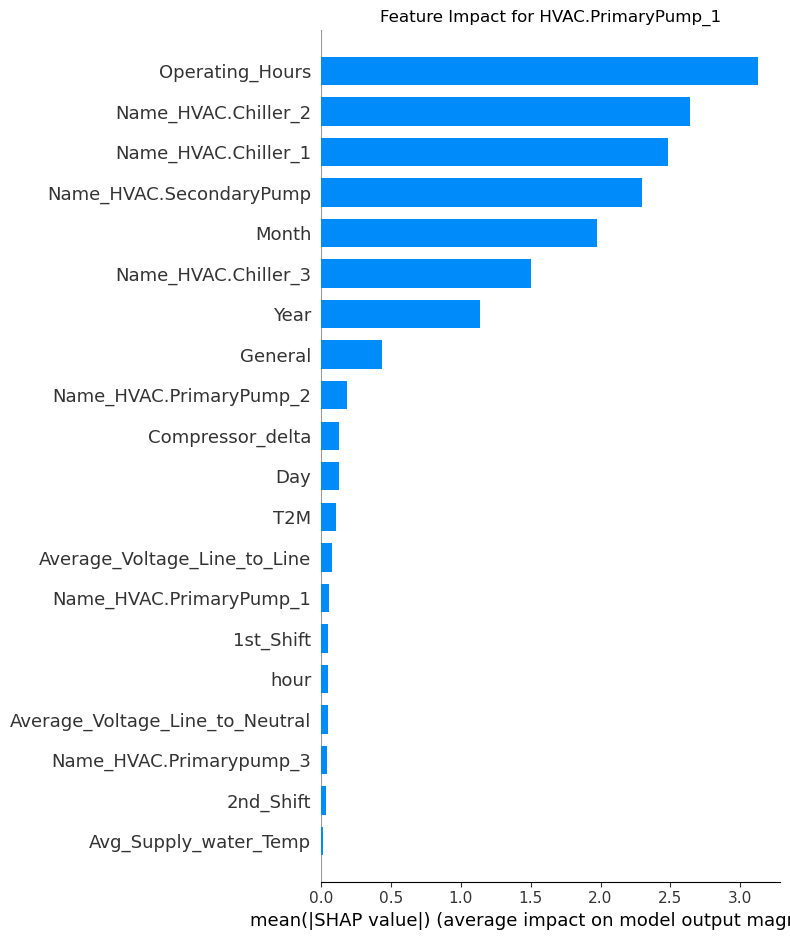


--- SHAP Summary for: HVAC.Chiller_3 ---


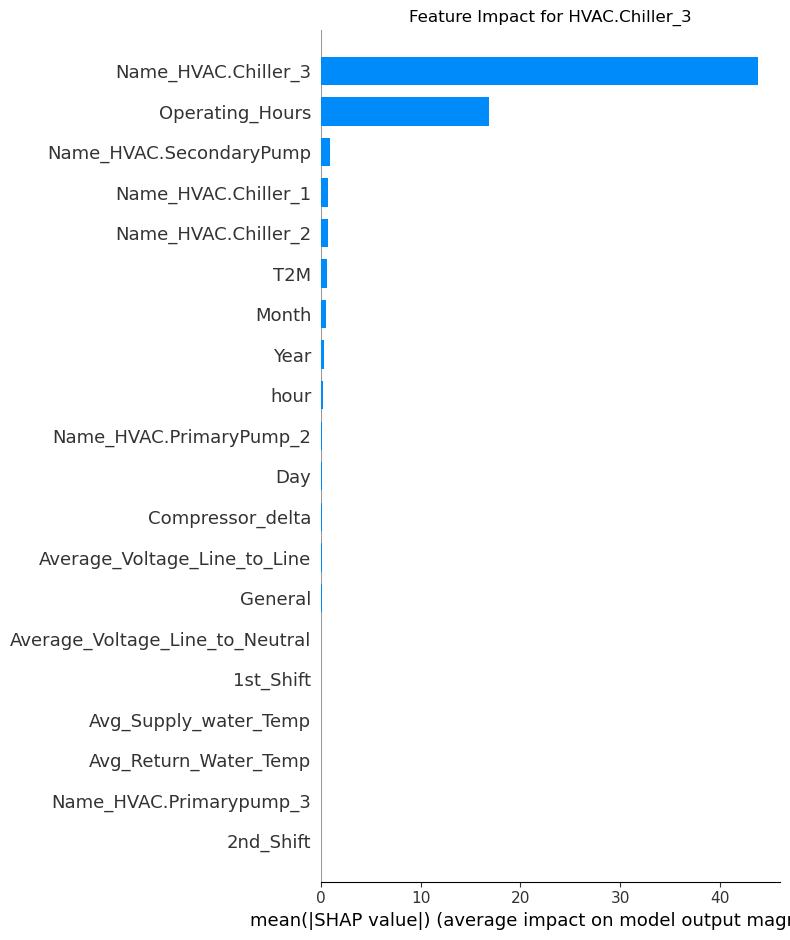


--- SHAP Summary for: HVAC.SecondaryPump ---


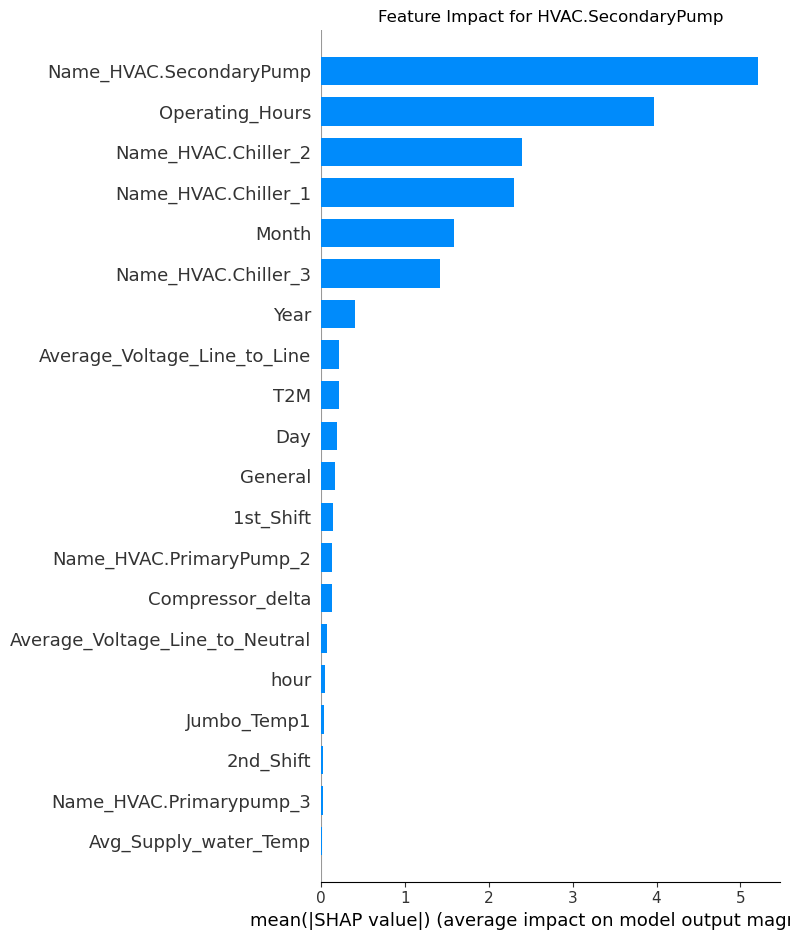


--- SHAP Summary for: HVAC.Primarypump_3 ---


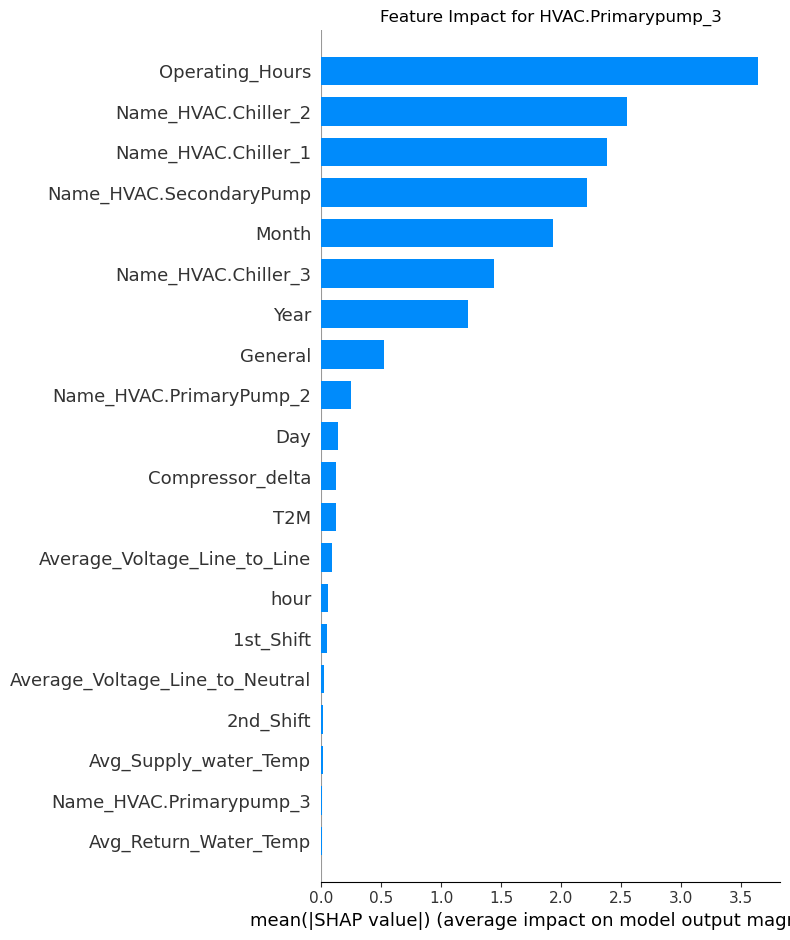


--- SHAP Summary for: HVAC.Chiller_2 ---


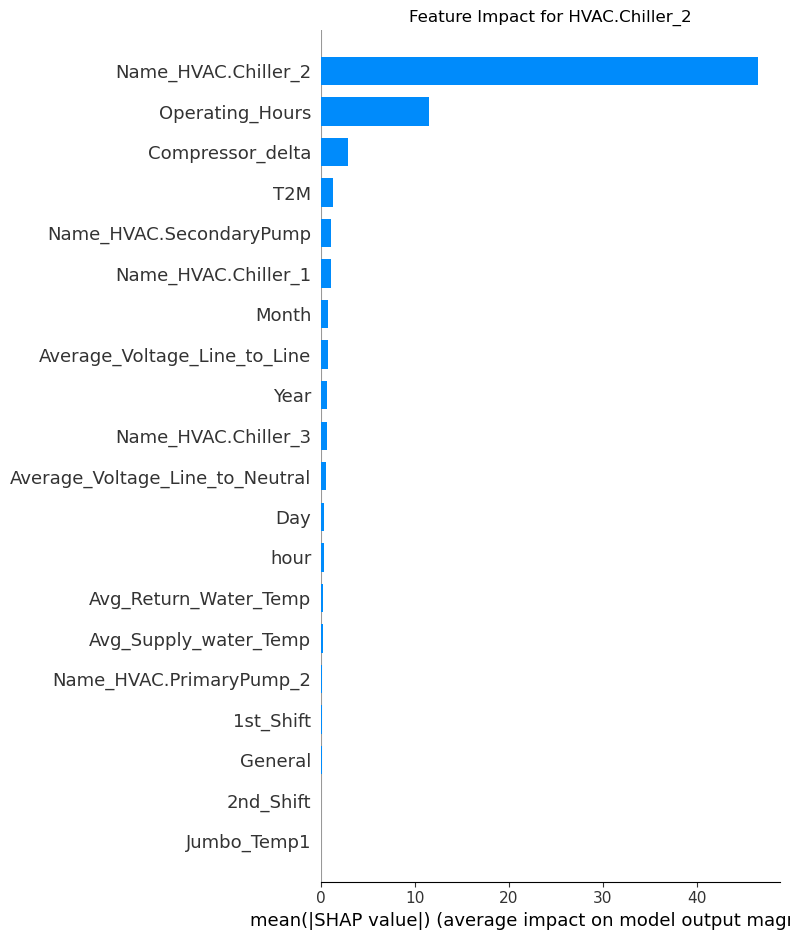


--- SHAP Summary for: HVAC.PrimaryPump_2 ---


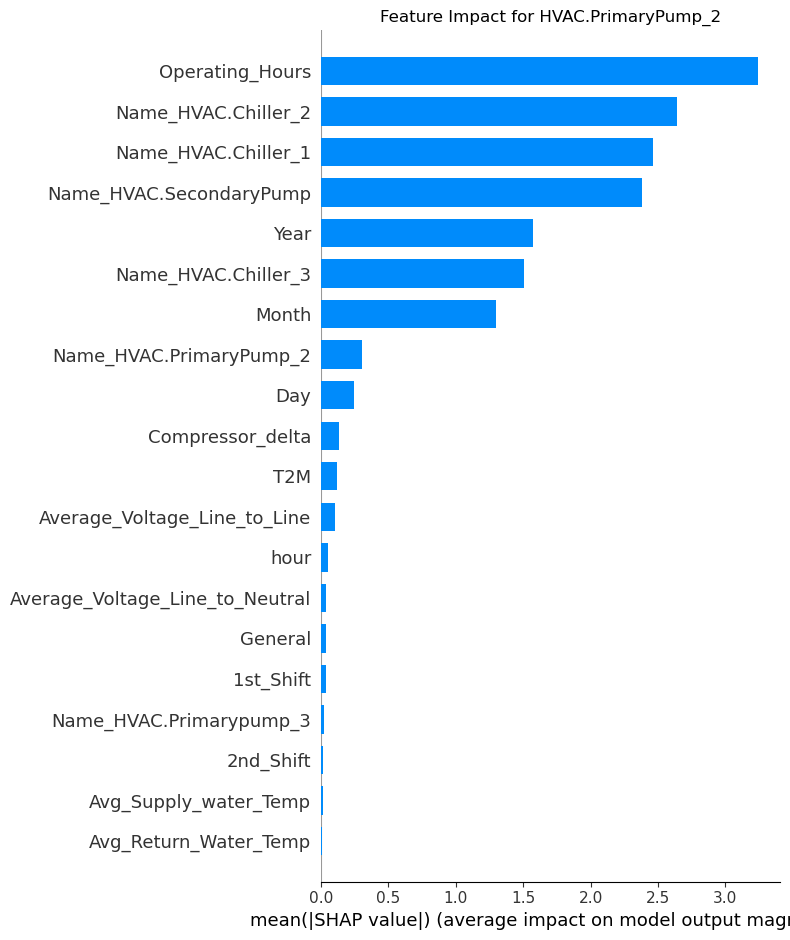


--- SHAP Summary for: HVAC.Chiller_1 ---


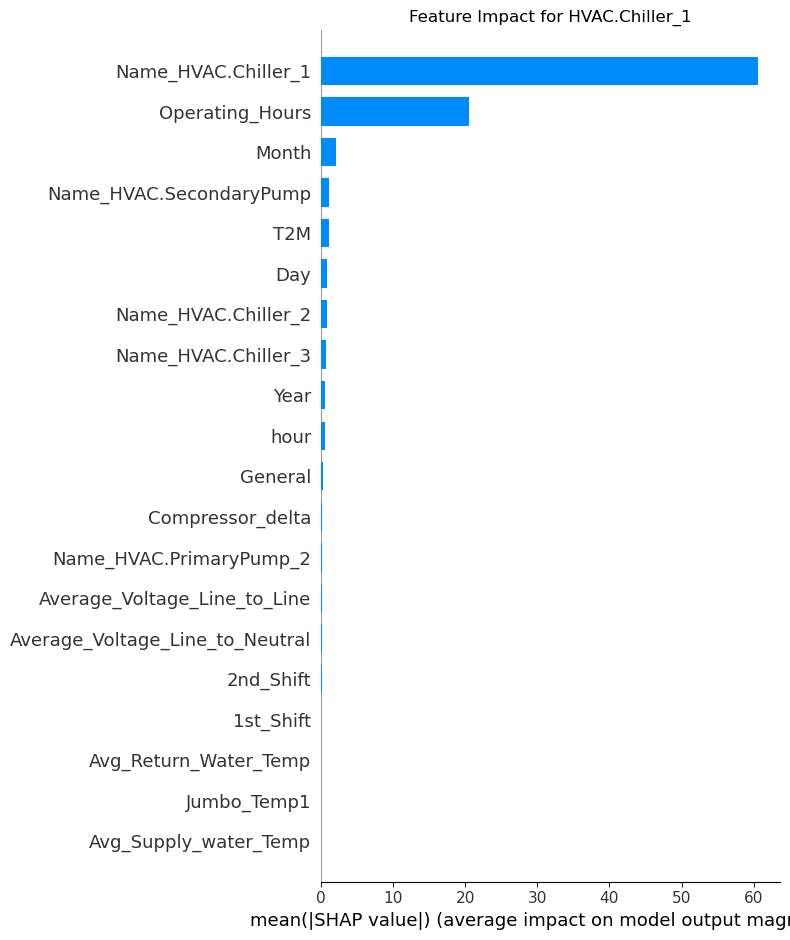


--- Creating Detailed Output File ---
Calculating top 3 impactful features for each prediction...
Matching feature names to their actual values...
Full results dataframe is now created.
Sample of detailed results:
                     Name        T2M  Operating_Hours  Actual_Power_Consumption  Jumbo_Temp1  Jumbo_Humidity  Average_Voltage_Line_to_Line  Year  Month  Day       Date  hour  Avg_Supply_water_Temp  Average_Voltage_Line_to_Neutral  Avg_Return_Water_Temp  Compressor_delta  1st_Shift  2nd_Shift  common  General  Predicted_Power_Consumption     Error  Perc_Error Impact_Feature_1_Name Impact_Feature_2_Name Impact_Feature_3_Name  Impact_Feature_1_Value  Impact_Feature_2_Value  Impact_Feature_3_Value
17590  HVAC.PrimaryPump_1  21.791667         0.596111                     4.299          0.0             0.0                   1662.497833    25     10    4 2025-10-04     7                    0.0                       959.856613                    0.0               0.0        0.0     

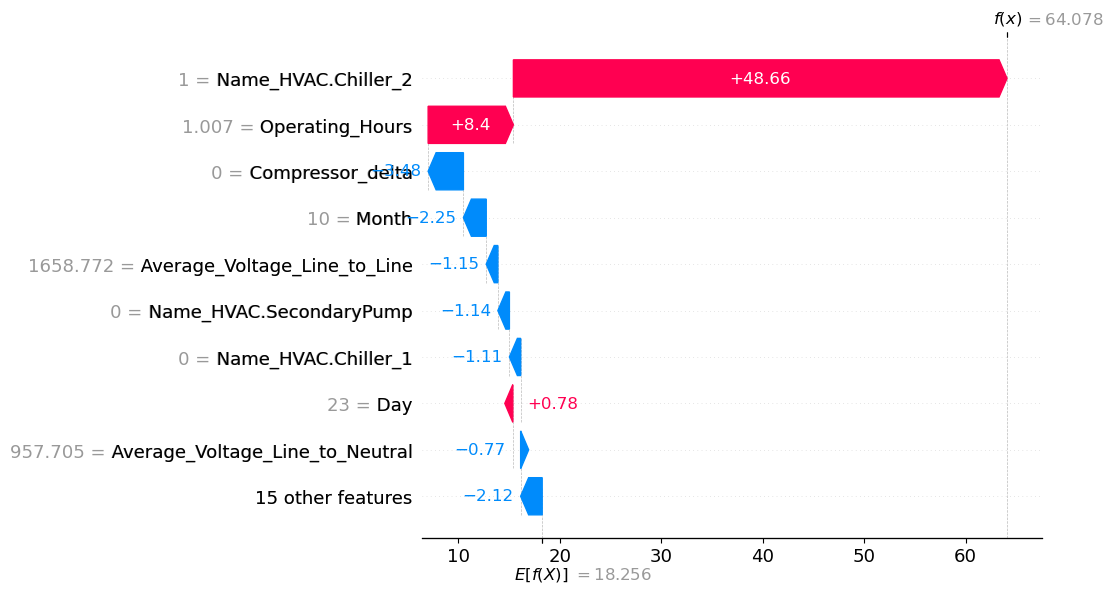


SHAP Summary Plot for *all* high-deviation instances:
This shows which features are most responsible for large errors *overall*.


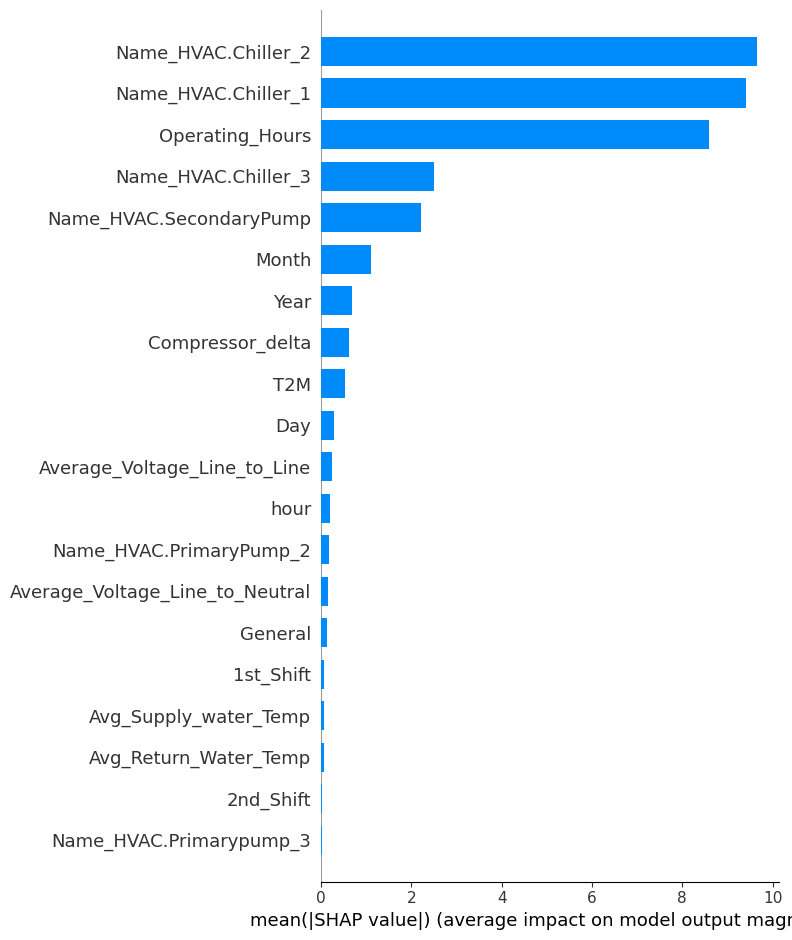


--- Model Building and Analysis Complete ---


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Model and metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# --- Configuration ---
# DATA_FILE_PATH = "E:/HVAC/preprocessed_data.xlsx"  # <-- Your data file

# Define your target and features
TARGET_VARIABLE = 'Active_Energy_Delivered'

NUMERICAL_FEATURES = [
    'T2M', 'Operating_Hours', 'Jumbo_Temp1', 'Jumbo_Humidity',
    'Average_Voltage_Line_to_Line', 'Year', 'Month', 'Day', 'hour',
    'Avg_Supply_water_Temp', 'Avg_Return_Water_Temp',
    'Average_Voltage_Line_to_Neutral', 'Compressor_delta',
    '1st_Shift', '2nd_Shift', 'common', 'General'
]
CATEGORICAL_FEATURES = ['Name']

# --- 1. Load and Prepare Data ---

print("Loading and preparing data from single file...")
try:
    #df = pd.read_excel(DATA_FILE_PATH)
    df = df.fillna(0)
except FileNotFoundError:
    print(f"Error: Data file not found at {DATA_FILE_PATH}")
    # # Create a dummy dataframe for demonstration purposes if file not found
    # dates = pd.date_range(start='2023-01-01', end='2024-05-27', freq='h')
    # df = pd.DataFrame(index=dates)
    # df['Date'] = df.index.date
    # df['hour'] = df.index.hour
    # df['Month'] = df.index.month
    # df['Day'] = df.index.day
    # df['Year'] = df.index.year
    # df['Name'] = np.random.choice(['Chilling1', 'Chilling2', 'Chilling3'], size=len(df))
    # df['Active_Energy_Delivered'] = np.random.rand(len(df)) * 100 + np.sin(df['hour'] * np.pi / 12) * 20 + 50
    # for col in NUMERICAL_FEATURES:
    #     if col not in df.columns:
    #         df[col] = np.random.rand(len(df))
    # print("Loaded dummy data for demonstration.")

# Ensure 'Date' is a datetime object for correct splitting
df['Date'] = pd.to_datetime(df['Date'])

# Sort data by time
df = df.sort_values(by=['Date', 'hour']).reset_index(drop=True)

# --- 2. Split Data (Train vs. Test) ---
today = df['Date'].max()
split_date = today - pd.Timedelta(days=30)
train_df = df[df['Date'] < split_date].copy()
test_df = df[df['Date'] >= split_date].copy()

print(f"Full dataset shape: {df.shape}")
print(f"Using data up to {today.date()} as 'today'.")
print(f"Training data shape: {train_df.shape} (Data before {split_date.date()})")
print(f"Test data shape: {test_df.shape} (Data from {split_date.date()} onwards)")

# --- 3. Feature Engineering: One-Hot Encoding 'Name' ---
print("\nApplying One-Hot Encoding to 'Name'...")
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(train_df[CATEGORICAL_FEATURES])
encoded_feature_names = ohe.get_feature_names_out(CATEGORICAL_FEATURES)
print(f"New encoded features: {list(encoded_feature_names)}")

train_encoded_features = ohe.transform(train_df[CATEGORICAL_FEATURES])
test_encoded_features = ohe.transform(test_df[CATEGORICAL_FEATURES])

train_encoded_df = pd.DataFrame(train_encoded_features, columns=encoded_feature_names, index=train_df.index)
test_encoded_df = pd.DataFrame(test_encoded_features, columns=encoded_feature_names, index=test_df.index)

X_train = pd.concat([train_df[NUMERICAL_FEATURES], train_encoded_df], axis=1)
X_test = pd.concat([test_df[NUMERICAL_FEATURES], test_encoded_df], axis=1)

y_train = train_df[TARGET_VARIABLE]
y_test = test_df[TARGET_VARIABLE]

ALL_FEATURES = NUMERICAL_FEATURES + list(encoded_feature_names)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# --- 4. Objective 4: Correlation Matrix ---
print("\n--- Objective 4: Correlation Analysis (on Training Data) ---")
numerical_data = train_df[NUMERICAL_FEATURES + [TARGET_VARIABLE]]
corr_matrix = numerical_data.corr()
target_corr = corr_matrix[TARGET_VARIABLE].sort_values(ascending=False)
print(f"Correlation with '{TARGET_VARIABLE}':\n{target_corr.head(10)}")

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features and Target')
plt.show()

# --- 5. Objectives 1, 2 & 5: Model Training, Evaluation, and Prediction ---
print("\n--- Objectives 1, 2 & 5: Training, Evaluation, and Prediction ---")
print(f"Training Random Forest on all {X_train.shape[0]} training samples...")
# Using the regularized model (min_samples_leaf=10)
rf_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=10,n_jobs=-1, oob_score=True)
rf_model.fit(X_train, y_train)

print("Calculating evaluation metrics...")
y_train_pred = rf_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

y_test_pred = rf_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"--- Global Model Metrics ---")
print(f"  Train: RMSE={train_rmse:.2f}, MSE={train_mse:.2f}, R²={train_r2:.2f}")
print(f"  Test:  RMSE={test_rmse:.2f}, MSE={test_mse:.2f}, R²={test_r2:.2f}")
print(f"  OOB Score (Out-of-Bag): {rf_model.oob_score_:.4f}")

# --- Create final results dataframe for the test period (Objective 5) ---
print("\n--- Objective 5: Predictions for Recent Data (Test Set) ---")
results_df = test_df.copy()
results_df = results_df.rename(columns={TARGET_VARIABLE: 'Actual_Power_Consumption'})
results_df['Predicted_Power_Consumption'] = y_test_pred
print("Sample of predictions vs. actuals for the test period:")
print(results_df.head())

# --- 6. Objective 3: Feature Importance (Global and Per-Machine) ---
print("\n--- Objective 3: Feature Importance ---")
print("Calculating Global Feature Importances...")
global_importances = rf_model.feature_importances_
global_importance_df = pd.DataFrame({
    'Feature': ALL_FEATURES,
    'Importance': global_importances
}).sort_values(by='Importance', ascending=False)
print(f"Top 10 Global Features:\n{global_importance_df.head(10)}")

print("\nCalculating Per-Machine Feature Importances using SHAP...")
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
shap_df = pd.DataFrame(shap_values, columns=ALL_FEATURES, index=X_test.index)
X_test_with_machine = X_test.join(test_df['Name'])

for machine in test_df['Name'].unique():
    print(f"\n--- SHAP Summary for: {machine} ---")
    machine_indices = X_test_with_machine[X_test_with_machine['Name'] == machine].index
    machine_shap_values = shap_df.loc[machine_indices].values
    machine_X_test = X_test.loc[machine_indices]
    if machine_X_test.empty:
        print("No test data for this machine.")
        continue
    plt.title(f"Feature Impact for {machine}")
    shap.summary_plot(machine_shap_values, machine_X_test, plot_type="bar", show=True)


# --- 7. NEW: Create Detailed Output with Feature Impacts ---
print("\n--- Creating Detailed Output File ---")

# Add error calculations to our results_df
results_df['Error'] = results_df['Actual_Power_Consumption'] - results_df['Predicted_Power_Consumption']
results_df['Perc_Error'] = 100 * (results_df['Error'] / results_df['Actual_Power_Consumption']).replace([np.inf, -np.inf, np.nan], 0)

print("Calculating top 3 impactful features for each prediction...")
# We already have shap_df from Step 6.
# Create a dataframe of absolute shap values
# abs_shap_df = shap_df.abs()
abs_shap_df_numerical = shap_df[NUMERICAL_FEATURES].abs()
# Get the column names (features) for the 3 largest values in each row
top_3_features_series = abs_shap_df_numerical.apply(lambda row: row.nlargest(3).index.tolist(), axis=1)

# Split this Series into three new columns in results_df
results_df['Impact_Feature_1_Name'] = top_3_features_series.str[0]
results_df['Impact_Feature_2_Name'] = top_3_features_series.str[1]
results_df['Impact_Feature_3_Name'] = top_3_features_series.str[2]

# Now, get the actual values for these features from X_test
print("Matching feature names to their actual values...")
results_df['Impact_Feature_1_Value'] = results_df.apply(
    lambda row: X_test.loc[row.name, row['Impact_Feature_1_Name']], axis=1
)
results_df['Impact_Feature_2_Value'] = results_df.apply(
    lambda row: X_test.loc[row.name, row['Impact_Feature_2_Name']], axis=1
)
results_df['Impact_Feature_3_Value'] = results_df.apply(
    lambda row: X_test.loc[row.name, row['Impact_Feature_3_Name']], axis=1
)

print("Full results dataframe is now created.")
print("Sample of detailed results:")
print(results_df.head())

# --- 8. NEW: Save Final Output and Analyze Deviations ---
# This is the output you requested
output_file_name = "E:/HVAC/hvac_prediction_results_with_features.xlsx"
try:
    results_df.to_excel(output_file_name, index=False)
    print(f"\nSuccessfully saved detailed results to: {output_file_name}")
except Exception as e:
    print(f"\nError saving to Excel: {e}")
    print("Saving as CSV instead...")
    output_file_name_csv = "E:/HVAC/hvac_prediction_results_with_features.xlsx"
    results_df.to_csv(output_file_name_csv, index=False)
    print(f"Successfully saved detailed results to: {output_file_name_csv}")

# --- Objective 6 (Modified): Analyze Deviations from the detailed results ---
print("\n--- Objective 6: Analyzing Large Deviations (>20%) ---")

# Find instances with > 20% deviation
deviation_rows = results_df[abs(results_df['Perc_Error']) > 20]

if deviation_rows.empty:
    print("No significant deviations (>20%) found in the test set. Model is performing well!")
else:
    print(f"Found {len(deviation_rows)} instances with >20% error.")
    
    # Print the requested columns for the deviation rows
    print("\n--- Details for High-Deviation Rows (from the saved file) ---")
    columns_to_show = [
        'Date', 'hour', 'Name', 'Actual_Power_Consumption', 'Predicted_Power_Consumption',
        'Error', 'Perc_Error', 'Impact_Feature_1_Name', 'Impact_Feature_1_Value',
        'Impact_Feature_2_Name', 'Impact_Feature_2_Value', 'Impact_Feature_3_Name', 'Impact_Feature_3_Value'
    ]
    # Set display options to see all columns
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(deviation_rows[columns_to_show])
    
    # Continue with SHAP plot for the worst one
    print("\nAnalyzing the single *worst* deviation with SHAP plot...")
    
    worst_deviation_idx_loc = deviation_rows['Error'].abs().idxmax()
    worst_deviation_int_loc = X_test.index.get_loc(worst_deviation_idx_loc)
    
    print(f"\n--- Explaining Instance (Index: {worst_deviation_idx_loc}) ---")
    print(f"  Date: {results_df.loc[worst_deviation_idx_loc, 'Date'].date()}")
    print(f"  Hour: {results_df.loc[worst_deviation_idx_loc, 'hour']}")
    print(f"  Machine: {results_df.loc[worst_deviation_idx_loc, 'Name']}")
    print(f"  Actual Power: {results_df.loc[worst_deviation_idx_loc, 'Actual_Power_Consumption']:.2f}")
    print(f"  Predicted Power: {results_df.loc[worst_deviation_idx_loc, 'Predicted_Power_Consumption']:.2f}")
    print(f"  Error: {results_df.loc[worst_deviation_idx_loc, 'Error']:.2f} ({results_df.loc[worst_deviation_idx_loc, 'Perc_Error']:.1f}%)")
    print(f"  Top 3 Drivers: ")
    print(f"    1. {results_df.loc[worst_deviation_idx_loc, 'Impact_Feature_1_Name']} = {results_df.loc[worst_deviation_idx_loc, 'Impact_Feature_1_Value']}")
    print(f"    2. {results_df.loc[worst_deviation_idx_loc, 'Impact_Feature_2_Name']} = {results_df.loc[worst_deviation_idx_loc, 'Impact_Feature_2_Value']}")
    print(f"    3. {results_df.loc[worst_deviation_idx_loc, 'Impact_Feature_3_Name']} = {results_df.loc[worst_deviation_idx_loc, 'Impact_Feature_3_Value']}")


    print("\nThis SHAP plot shows *why* the model made its prediction.")
    print("Features pushing the prediction HIGHER are in red.")
    print("Features pushing the prediction LOWER are in blue.")
    
    # shap.initjs() # Uncomment if running in a Jupyter Notebook
    
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[worst_deviation_int_loc],
        base_values=explainer.expected_value,
        data=X_test.iloc[worst_deviation_int_loc],
        feature_names=ALL_FEATURES
    ))
    
    # Summary plot for ALL deviations
    deviation_indices = X_test.index.isin(deviation_rows.index)
    deviation_shap_values = shap_values[deviation_indices]
    deviation_X_test = X_test[deviation_indices]

    print("\nSHAP Summary Plot for *all* high-deviation instances:")
    print("This shows which features are most responsible for large errors *overall*.")
    shap.summary_plot(deviation_shap_values, deviation_X_test, plot_type="bar")
    
print("\n--- Model Building and Analysis Complete ---")

In [ ]:
 Train: RMSE=4.66, MSE=21.69, R²=0.95
  Test:  RMSE=8.39, MSE=70.32, R²=0.92
  OOB Score (Out-of-Bag): 0.9188

In [ ]:
--- Global Model Metrics ---
  Train: RMSE=4.64, MSE=21.49, R²=0.95
  Test:  RMSE=8.55, MSE=73.06, R²=0.92
  OOB Score (Out-of-Bag): 0.9192

# Entire code

In [126]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder # No longer needed for this approach
import shap  # Make sure SHAP is installed: pip install shap
import traceback  # For detailed error printing
import warnings  # To suppress potential warnings if desired

# Optional: Suppress SHAP UserWarnings
warnings.filterwarnings('ignore', category=UserWarning, module='shap')

# --- Database Connection Details ---
# !!! IMPORTANT: Replace with your actual credentials or use a secure method !!!
# Consider environment variables or a config file instead of hardcoding
server_name = '10.10.9.32'
database_name = 'TLMAL'
user_id = 'taslview'
password = 'New@1234'  # This is insecure - manage secrets properly!
# Ensure this driver is installed and matches your system (e.g., '{ODBC Driver 17 for SQL Server}')
driver = '{SQL Server}'

# --- Database Connection ---
try:
    # F-string requires Python 3.6+
    connection_string = f"Driver={driver};Server={server_name};Database={database_name};UID={user_id};PWD={password}"
    conn = pyodbc.connect(connection_string)
    print("Database connection successful.")
except Exception as e:
    print(f"Database connection failed: {e}")
    print("Please ensure the SQL Server is running, credentials are correct,")
    print("the specified ODBC driver is installed, and network connectivity is okay.")
    # Exit or handle error appropriately if connection fails
    exit()

# --- SQL Query to Fetch Data ---
Power = '''SELECT [Time-Hourly]
      ,[Name]
      ,[Active_Energy_Delivered]
      ,[Operating_Hours]
      ,[Average_Voltage_Line_to_Neutral]
      ,[Average_Voltage_Line_to_Line]
      ,[Jumbo_Humidity3]
      ,[Jumbo_Temp2]
      ,[Jumbo_Temp1]
      ,[Jumbo_Temp3]
      ,[Jumbo_Humidity]
      ,[T2M]
      ,[Date_Time]
      ,[Avg_Return_Water_Temp]
      ,[Avg_Supply_water_Temp]
      ,[TimeStamp]
      ,[Year]
      ,[Month]
      ,[Day]
      ,[hour]
      ,[Date]
      ,[Start Date]
      ,[1st_Shift]
      ,[2nd_Shift]
      ,[3rd_Shift]
      ,[common]
      ,[General]
      ,[Left_Right_Name]
      ,[Score]
      ,[Right_Date_Time]
      ,[Right_3rd_Shift]
      ,[Result]
  FROM [TLMAL].[dbo].[HVAC_Regression]'''  # Consider adding WHERE clauses here if possible to reduce data fetched

try:
    print("Fetching data from database...")
    data = pd.read_sql(Power, conn)
    conn.close()  # Close connection immediately after fetching data
    print("Data fetched successfully.")
    # Optional: Save raw data
    # data.to_excel("raw_hvac_data.xlsx", index=False)
except Exception as e:
    print(f"Failed to fetch data: {e}")
    traceback.print_exc()  # Print full traceback for SQL errors
    exit()

print("Initial data shape:", data.shape)
print("Initial columns:", data.columns.tolist())
print("Initial data types:\n", data.dtypes)  # Check initial types

# --- Data Preprocessing ---
print("\nStarting Data Preprocessing...")
# Rename inconsistent names
if 'Name' in data.columns:
    data['Name'] = data['Name'].replace('AHU1.1', 'AHU.1')
    # Filter for relevant names (Still useful to filter rows, even if 'Name' isn't used as a feature)
    data = data[data['Name'].str.contains('HVAC', na=False)]
    print(f"Shape after filtering Name: {data.shape}")
else:
    print("Warning: 'Name' column not found for filtering.")


# Filter target variable range
if 'Active_Energy_Delivered' in data.columns:
    # Ensure target is numeric before filtering
    data['Active_Energy_Delivered'] = pd.to_numeric(
        data['Active_Energy_Delivered'], errors='coerce')
    # Drop rows where conversion failed
    data.dropna(subset=['Active_Energy_Delivered'], inplace=True)
    data = data[(data['Active_Energy_Delivered'] >= 0) &
                (data['Active_Energy_Delivered'] < 120)]  # Adjust upper limit if needed
    print(f"Shape after filtering Active_Energy_Delivered: {data.shape}")
else:
    print("Error: Target column 'Active_Energy_Delivered' not found. Exiting.")
    exit()


# Convert Date and handle errors
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    initial_rows = data.shape[0]
    data = data.dropna(subset=['Date'])
    print(
        f"Dropped {initial_rows - data.shape[0]} rows due to invalid Date format.")
    print(f"Shape after handling Date: {data.shape}")
    data = data.sort_values(by='Date')
else:
    print("Error: 'Date' column not found for train/test split. Exiting.")
    exit()


# Impute Jumbo Temperature and Humidity (Check column existence first)
temp_cols_exist = all(col in data.columns for col in [
                      'Jumbo_Temp1', 'Jumbo_Temp2', 'Jumbo_Temp3'])
humidity_cols_exist = all(col in data.columns for col in [
                          'Jumbo_Humidity', 'Jumbo_Humidity3'])

if temp_cols_exist:
    print("Imputing Jumbo Temperatures...")
    # Convert to numeric first
    for col in ['Jumbo_Temp1', 'Jumbo_Temp2', 'Jumbo_Temp3']:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data['Jumbo_Temp1'] = data['Jumbo_Temp1'].fillna(
        data['Jumbo_Temp2']).fillna(data['Jumbo_Temp3'])
else:
    print("Warning: One or more Jumbo Temperature columns missing, skipping imputation.")

if humidity_cols_exist:
    print("Imputing Jumbo Humidity...")
    # Convert to numeric first
    for col in ['Jumbo_Humidity', 'Jumbo_Humidity3']:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data['Jumbo_Humidity'] = data['Jumbo_Humidity'].fillna(
        data['Jumbo_Humidity3'])
else:
    print("Warning: One or more Jumbo Humidity columns missing, skipping imputation.")

# Drop redundant columns if they exist AND imputation was attempted
cols_to_drop = []
if temp_cols_exist:
    cols_to_drop.extend(['Jumbo_Temp2', 'Jumbo_Temp3'])
if humidity_cols_exist:
    cols_to_drop.append('Jumbo_Humidity3')

data.drop(
    columns=[col for col in cols_to_drop if col in data.columns], inplace=True)
print(
    f"Dropped redundant columns: {[col for col in cols_to_drop if col in data.columns]}")


# Forward/Backward fill remaining NaNs for imputed columns
if 'Jumbo_Temp1' in data.columns:
    initial_nan = data['Jumbo_Temp1'].isna().sum()
    data['Jumbo_Temp1'] = data['Jumbo_Temp1'].ffill().bfill()
    print(
        f"Filled {initial_nan - data['Jumbo_Temp1'].isna().sum()} NaNs in Jumbo_Temp1.")
if 'Jumbo_Humidity' in data.columns:
    initial_nan = data['Jumbo_Humidity'].isna().sum()
    data['Jumbo_Humidity'] = data['Jumbo_Humidity'].ffill().bfill()
    print(
        f"Filled {initial_nan - data['Jumbo_Humidity'].isna().sum()} NaNs in Jumbo_Humidity.")

# Filter based on T2M and Operating_Hours (Check column existence and convert to numeric)
if 'T2M' in data.columns:
    data['T2M'] = pd.to_numeric(data['T2M'], errors='coerce')
    data.dropna(subset=['T2M'], inplace=True)
    # Adjusted plausible range
    data = data[(data['T2M'] > 0) & (data['T2M'] < 50)]
    print(f"Shape after filtering T2M: {data.shape}")
else:
    print("Warning: 'T2M' column not found for filtering.")

if 'Operating_Hours' in data.columns:
    data['Operating_Hours'] = pd.to_numeric(
        data['Operating_Hours'], errors='coerce')
    data.dropna(subset=['Operating_Hours'], inplace=True)
    # Allow zero operating hours, but filter extremes
    data = data[(data['Operating_Hours'] >= 0) &
                (data['Operating_Hours'] < 1.1)]  # Keep upper bound reasonable
    print(f"Shape after filtering Operating_Hours: {data.shape}")
else:
    print("Warning: 'Operating_Hours' column not found for filtering.")


# Create Compressor_delta (Check column existence)
if 'Avg_Return_Water_Temp' in data.columns and 'Avg_Supply_water_Temp' in data.columns:
    # Ensure columns are numeric before subtraction
    data['Avg_Return_Water_Temp'] = pd.to_numeric(
        data['Avg_Return_Water_Temp'], errors='coerce')
    data['Avg_Supply_water_Temp'] = pd.to_numeric(
        data['Avg_Supply_water_Temp'], errors='coerce')
    # Only calculate delta if both are non-null
    mask = data['Avg_Return_Water_Temp'].notna(
    ) & data['Avg_Supply_water_Temp'].notna()
    data.loc[mask, 'Compressor_delta'] = data.loc[mask, 'Avg_Return_Water_Temp'] - \
        data.loc[mask, 'Avg_Supply_water_Temp']
    print("Compressor_delta created for valid rows.")
    # Optionally fill remaining NaNs in Compressor_delta if needed, e.g., with 0 or median
    # data['Compressor_delta'].fillna(0, inplace=True)
else:
    print("Warning: Water temperature columns missing, cannot create Compressor_delta.")


# Select final features - INCLUDING 'Name' initially for filtering rows if needed,
# but it will be EXCLUDED from X_train/X_test later.
# Make sure all desired numerical features are included here
final_columns_base = [
    'Name', 'T2M', 'Operating_Hours', 'Active_Energy_Delivered',
    'Year', 'Month', 'Day', 'hour', 'Date',  # Keep Date for splitting
    'Avg_Supply_water_Temp', 'Avg_Return_Water_Temp',
    # Include 3rd_Shift if relevant
    'Compressor_delta', '1st_Shift', '2nd_Shift', '3rd_Shift',
    'common', 'General',
    # Add other potentially relevant numeric columns if available and preprocessed
    'Current_Phase_Average', 'Average_Voltage_Line_to_Neutral', 'Average_Voltage_Line_to_Line',
    'Jumbo_Temp1', 'Jumbo_Humidity'
]
# Keep only columns that actually exist in the dataframe after preprocessing
available_final_columns = [
    col for col in final_columns_base if col in data.columns]
print(
    f"\nUsing available columns for final selection: {available_final_columns}")

# Filter the dataframe to only these columns
# Use .copy() to avoid SettingWithCopyWarning
data = data[available_final_columns].copy()

# --- Final Check for NaNs before Split ---
print("\nChecking for NaNs before train/test split:")
nan_counts = data.isna().sum()
print(nan_counts[nan_counts > 0])
# Decide on a strategy for remaining NaNs (e.g., fill with 0, median, mean, or drop rows)
# Filling with 0 is simple but might not be optimal for all features.
# Consider feature-specific imputation if large numbers of NaNs remain.
print("Filling remaining NaNs with 0 before split (consider if this is appropriate for all columns)...")
data.fillna(0, inplace=True)


print("\nPreprocessing completed.")
print("Final data shape before split:", data.shape)
print("Final columns before split:", data.columns.tolist())
print("Final data types before split:\n", data.dtypes)

# --- Train-Test Split ---
if data.empty or 'Date' not in data.columns:
    print("Data is empty or 'Date' column missing after preprocessing. Cannot split.")
    exit()

# Ensure 'Date' is still datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
if data['Date'].isna().any():
    print("Warning: NaNs found in 'Date' column even after preprocessing checks. Dropping affected rows.")
    data.dropna(subset=['Date'], inplace=True)

if data.empty:
    print("Data became empty after final Date check. Cannot split.")
    exit()

split_days = 30
print(f"\nSplitting data: Last {split_days} days for testing.")
test_cutoff_date = data['Date'].max() - pd.Timedelta(days=split_days)
train_data = data[data['Date'] <= test_cutoff_date].copy()
test_data = data[data['Date'] > test_cutoff_date].copy()

print(
    f"Train data range: {train_data['Date'].min()} to {train_data['Date'].max()}")
print(
    f"Test data range: {test_data['Date'].min()} to {test_data['Date'].max()}")


if train_data.shape[0] == 0:
    raise ValueError(
        "Training data is empty after split. Check date range and filtering.")
if test_data.shape[0] == 0:
    raise ValueError(
        "Test data is empty after split. Check date range and filtering.")

# Handle potential NaNs AGAIN after split (although we filled earlier, good practice)
# Using fillna(0) as per the original code's logic after split.
train_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)


# Drop Date column (must be done AFTER split and potential usage)
train_data.drop(columns=['Date'], axis=1, inplace=True)
test_data.drop(columns=['Date'], axis=1, inplace=True)


# Reset index
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

print("\nTrain-Test Split completed.")
print("Training set shape before dropping non-numerics:", train_data.shape)
print("Testing set shape before dropping non-numerics:", test_data.shape)

# --- Model Training and Evaluation (NUMERICAL FEATURES ONLY) ---
if not train_data.empty and 'Active_Energy_Delivered' in train_data.columns:
    print("\nStarting Model Training (NUMERICAL FEATURES ONLY)...")

    # Prepare data for modeling - Select ONLY numerical features EXPLICITLY
    target = 'Active_Energy_Delivered'

    # Identify numerical columns from train_data, excluding the target
    numerical_cols = train_data.select_dtypes(
        include=np.number).columns.tolist()
    if target in numerical_cols:
        numerical_cols.remove(target)  # Don't include target in features

    # Identify categorical columns to EXCLUDE
    categorical_cols = train_data.select_dtypes(
        include=['object', 'category']).columns.tolist()

    # --- DEBUG PRINT 1 ---
    print(
        f"\nDEBUG: Numerical columns selected for training: {numerical_cols}")
    # Manually check if 'Year', 'Month', 'Day', 'hour' are in this list.

    print(f"Using ONLY Numerical columns as features: {numerical_cols}")
    print(f"Excluding Categorical columns: {categorical_cols}")  # Like 'Name'
    print(f"Target column: {target}")

    # Ensure only existing numerical columns are used (redundant if selection is correct, but safe)
    numerical_cols = [
        col for col in numerical_cols if col in train_data.columns]

    X_train = train_data[numerical_cols]  # Select only numerical features
    y_train = train_data[target]

    # Ensure test set uses the same numerical columns IN THE SAME ORDER
    X_test = test_data[[
        col for col in numerical_cols if col in test_data.columns]]
    # Check if any columns are missing in test set that were in train set
    missing_in_test = set(X_train.columns) - set(X_test.columns)
    if missing_in_test:
        print(
            f"Warning: Columns {missing_in_test} present in training features but missing in test features. This might cause errors.")
        # Decide how to handle: drop from X_train, add dummy to X_test, or error out.
        # For simplicity here, we'll proceed, but be aware of potential issues.
        # A more robust solution might involve aligning columns after the split.

    # Ensure target exists in test data
    if target not in test_data.columns:
        raise ValueError(
            f"Target column '{target}' not found in test_data after preprocessing.")
    y_test = test_data[target]

    # --- DEBUG PRINT 2 ---
    print(
        f"\nDEBUG: X_train columns used for fitting: {X_train.columns.tolist()}")
    # Check again if time features are present here.
    print(f"DEBUG: X_train shape: {X_train.shape}")
    print(
        f"DEBUG: X_test columns before processing: {X_test.columns.tolist()}")
    print(f"DEBUG: X_test shape: {X_test.shape}")

    # Check if numerical columns list is empty or X_train is empty
    if not numerical_cols:
        raise ValueError(
            "No numerical features identified for training. Check data types and selection.")
    if X_train.empty:
        raise ValueError(
            "X_train is empty after selecting numerical features. Check filtering steps.")
    if X_test.empty:
        raise ValueError(
            "X_test is empty after selecting numerical features. Check filtering steps and split.")

    # --- Preprocessing Pipeline (Minimal for Numerical Only) ---
    # Using ColumnTransformer just to maintain pipeline structure, but only applying 'passthrough'.
    # This ensures column order consistency if more complex steps were added later.
    preprocessor = ColumnTransformer(
        transformers=[
            # Pass through all numerical columns provided
            ('num', 'passthrough', numerical_cols)
        ],
        # Drop any columns not explicitly passed (shouldn't be needed here)
        remainder='drop'
    )

    # Create and train model pipeline
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Ensures correct column handling
        # --- REGULARIZATION ADDED TO PREVENT OVERFITTING ---
        ('regressor', ExtraTreesRegressor(
            random_state=123,
            n_estimators=100,      # Number of trees in the forest
            n_jobs=-1,             # Use all available CPU cores
            # --- Parameters added to prevent overfitting ---
            # Limit how deep each tree can grow (tune this)
            max_depth=15,
            # Require at least 5 samples in each leaf node (tune this)
            min_samples_leaf=5,
            # Require at least 10 samples to split a node (tune this)
            min_samples_split=10,
            # Consider adding max_features (e.g., 'sqrt' or a float < 1.0)
            # max_features='sqrt',
            oob_score=False  # Can set to True to estimate generalization error without test set
        ))
        # --- End of Regularization Parameters ---
    ])

    try:
        print("\nFitting the model pipeline...")
        model.fit(X_train, y_train)
        print("Model training finished.")
    except Exception as e:
        print(f"Error during model training: {e}")
        print("X_train columns:", X_train.columns.tolist())
        print("numerical_cols for preprocessor:", numerical_cols)
        print("X_train data types:\n", X_train.dtypes)
        print("Check for non-numeric data or NaNs that might have slipped through.")
        traceback.print_exc()
        raise e

    # Make predictions
    print("Making predictions...")
    train_predictions = model.predict(X_train)
    # Use the same columns for prediction as used in training
    test_predictions = model.predict(
        X_test[X_train.columns])  # Ensure column order

    # --- Evaluation Metrics ---
    # Define the evaluation function

    def evaluate_metrics(y_true, y_pred, dataset_name):
        # Ensure inputs are numpy arrays and not empty
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        if y_true.size == 0 or y_pred.size == 0:
            print(
                f"Warning: Empty arrays received for metric calculation in {dataset_name}.")
            return np.nan, np.nan, np.nan, np.nan
        if y_true.size != y_pred.size:
            print(
                f"Warning: Mismatched sizes for metric calculation in {dataset_name}. True: {y_true.size}, Pred: {y_pred.size}")
            # Attempt to align if shapes allow, otherwise return NaN
            min_size = min(y_true.size, y_pred.size)
            y_true = y_true[:min_size]
            y_pred = y_pred[:min_size]
            if min_size == 0:
                return np.nan, np.nan, np.nan, np.nan

        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        # Handle case where variance of y_true is zero
        if np.var(y_true) < 1e-9:  # Check for near-zero variance
            # R2 is NaN if variance is zero but error exists
            r2 = np.nan if mse > 1e-9 else 1.0
        else:
            r2 = r2_score(y_true, y_pred)

        print(
            f"\nEvaluation Metrics for {dataset_name} (Numerical Features Only Model):")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R-squared (R2) Score: {r2:.4f}")
        return mse, rmse, mae, r2

    # Call the evaluation function
    train_metrics = evaluate_metrics(
        y_train, train_predictions, "Training Set")
    test_metrics = evaluate_metrics(y_test, test_predictions, "Test Set")
    print("\nNote: Model accuracy might be lower as categorical features ('Name') were excluded.")
    print("Note: Training R2 score should ideally be < 1.0 due to regularization.")

    # --- Feature Importance Analysis (Global - Numerical Only) ---
    print("\nCalculating Global Feature Importance (Numerical Features Only)...")
    try:
        # Feature names are simply the numerical columns used for training
        # Use the list of columns actually present in X_train after selection
        feature_names = X_train.columns.tolist()

        # Get importances - directly corresponds to numerical_cols used
        importances = model.named_steps['regressor'].feature_importances_

        # Create DataFrame
        if len(feature_names) == len(importances):
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values(by='Importance', ascending=False)

            print("\nGlobal Feature Importance (Top 10 Numerical):")
            print(importance_df.head(10))

            # Plot feature importance
            plt.figure(figsize=(10, 8))
            num_features_to_plot = min(20, importance_df.shape[0])
            if num_features_to_plot > 0:
                sns.barplot(x='Importance', y='Feature',
                            data=importance_df.head(num_features_to_plot))
                plt.title(
                    'Top Numerical Global Feature Importance (Model using Numerical Only)')
                plt.xlabel('Importance Score (e.g., Gini importance)')
                plt.ylabel('Numerical Feature')
                plt.tight_layout()
                plt.savefig('numerical_only_model_global_importance.png')
                plt.close()
                print("Numerical-only model global feature importance plot saved.")
                print(
                    ">> Check 'numerical_only_model_global_importance.png' to see if Year/Month/Day/Hour appear.")
            else:
                print("No numerical features found to plot importance.")
        else:
            print(
                f"Error: Mismatch between feature names ({len(feature_names)}) and importances ({len(importances)}).")

    except Exception as e:
        print(
            f"\nCould not calculate or plot global feature importance: {str(e)}")
        traceback.print_exc()

    # --- Correlation Analysis ---
    # Remains valid as it uses numerical columns
    print("\nCalculating Correlation Matrix...")
    # Ensure target is included and use only selected numericals
    numeric_train_data_corr = train_data[numerical_cols + [target]].copy()
    # Ensure all columns are numeric for correlation
    for col in numeric_train_data_corr.columns:
        numeric_train_data_corr[col] = pd.to_numeric(
            numeric_train_data_corr[col], errors='coerce')
    # Drop rows where conversion failed
    numeric_train_data_corr.dropna(inplace=True)

    if target in numeric_train_data_corr.columns and not numeric_train_data_corr.empty:
        correlation_matrix = numeric_train_data_corr.corr()
        if target in correlation_matrix.columns:
            consumption_correlation = correlation_matrix[target].sort_values(
                ascending=False)
            print("\nCorrelation with Active Energy Delivered (Numerical Features):")
            print(consumption_correlation)

            plt.figure(figsize=(14, 12))  # Increased size for more features
            sns.heatmap(correlation_matrix, annot=True,
                        cmap='coolwarm', fmt='.2f', annot_kws={'size': 8})
            plt.title('Correlation Heatmap of Numerical Features Used in Model')
            plt.xticks(rotation=45, ha='right', fontsize=9)
            plt.yticks(rotation=0, fontsize=9)
            plt.tight_layout()
            plt.savefig('numerical_only_model_correlation_heatmap.png')
            plt.close()
            print("Numerical-only model correlation heatmap saved.")
        else:
            print(
                f"\n'{target}' column disappeared from correlation matrix after calculations.")
    else:
        print(f"\n'{target}' not found or data empty for correlation analysis.")

    # --- Trend Analysis ---
    # Remains valid as it uses original columns before feature selection
    print("\nPerforming Trend Analysis (Based on training data)...")
    # Use the original train_data before dropping columns for trends
    # Get original rows for train
    trend_train_data = data[data.index.isin(train_data.index)].copy()

    if 'Month' in trend_train_data.columns and 'hour' in trend_train_data.columns:
        # Monthly Trend Plot
        try:
            monthly_consumption = trend_train_data.groupby(
                'Month')['Active_Energy_Delivered'].mean()
            plt.figure(figsize=(10, 6))
            monthly_consumption.plot(kind='bar', color='skyblue')
            plt.title('Average Monthly Energy Consumption (Training Data)')
            plt.xlabel('Month')
            plt.ylabel('Avg Active Energy Delivered')
            plt.xticks(rotation=0)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.savefig('monthly_consumption_trend.png')
            plt.close()
            print("Monthly consumption trend plot saved as monthly_consumption_trend.png")
        except Exception as e:
            print(f"Could not plot monthly trend: {e}")

        # Hourly Trend Plot
        try:
            hourly_consumption = trend_train_data.groupby(
                'hour')['Active_Energy_Delivered'].mean().sort_index()  # Sort by hour
            plt.figure(figsize=(12, 6))
            hourly_consumption.plot(kind='bar', color='salmon')
            plt.title('Average Hourly Energy Consumption (Training Data)')
            plt.xlabel('Hour of Day (0-23)')
            plt.ylabel('Avg Active Energy Delivered')
            plt.xticks(rotation=0)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.savefig('hourly_consumption_trend.png')
            plt.close()
            print("Hourly consumption trend plot saved as hourly_consumption_trend.png")
        except Exception as e:
            print(f"Could not plot hourly trend: {e}")
    else:
        print("Month or hour column not available in original data for trend analysis.")

    # --- SHAP Analysis (Numerical Features Only) ---
    print("\nCalculating SHAP values for Test Set (Numerical Features Only Model)...")
    try:
        # 1. Get regressor (preprocessor step is minimal now)
        regressor = model.named_steps['regressor']
        # Keep for consistency if needed
        # Renamed to avoid conflict
        preprocessor_step = model.named_steps['preprocessor']

        # 2. Transform test data using the fitted preprocessor
        # Ensure X_test has the same columns as X_train used for fitting the preprocessor
        X_test_aligned = X_test[X_train.columns]  # Align columns explicitly
        X_test_processed = preprocessor_step.transform(X_test_aligned)
        # Check if sparse matrix and convert if needed (passthrough shouldn't make it sparse, but good practice)
        if hasattr(X_test_processed, "toarray"):
            print("Processed test data is sparse, converting to dense array for SHAP.")
            X_test_processed = X_test_processed.toarray()

        # 3. Feature names are just the numerical columns used for training/preprocessing
        processed_feature_names = X_train.columns.tolist()  # Use columns from X_train

        # --- DEBUG PRINT 3 ---
        print(
            f"\nDEBUG: Feature names for SHAP interpretation: {processed_feature_names}")
        print(
            f"DEBUG: Shape of processed test data for SHAP: {X_test_processed.shape}")
        # Ensure the number of columns in X_test_processed matches len(processed_feature_names)

        # 4. Create SHAP Explainer (TreeExplainer is suitable for ExtraTrees)
        print("Initializing SHAP TreeExplainer...")
        explainer = shap.TreeExplainer(regressor)

        # 5. Calculate SHAP values (only for numerical features)
        print("Calculating SHAP values (this may take some time)...")
        # Check expected value if needed: print(explainer.expected_value)
        shap_values = explainer.shap_values(
            X_test_processed)  # Use processed data
        # Should be (n_samples, n_features)
        print(f"SHAP values calculated. Shape: {shap_values.shape}")

        # Check if SHAP values calculation succeeded
        if shap_values is None or not isinstance(shap_values, np.ndarray) or shap_values.shape[1] != len(processed_feature_names):
            raise ValueError(
                f"SHAP calculation failed or returned unexpected shape. Expected features: {len(processed_feature_names)}, Got shape: {shap_values.shape if shap_values is not None else 'None'}")

        # 6. Find most impactful numerical feature for each prediction
        most_impactful_features = []
        shap_values_abs = np.abs(shap_values)
        for i in range(shap_values_abs.shape[0]):
            # Ensure index is within bounds
            if shap_values_abs.shape[1] > 0:
                max_impact_index = np.argmax(shap_values_abs[i, :])
                # Double check index validity
                if max_impact_index < len(processed_feature_names):
                    most_impactful_feature_name = processed_feature_names[max_impact_index]
                    most_impactful_features.append(most_impactful_feature_name)
                else:
                    # Handle unexpected index case (should not happen if shapes match)
                    print(
                        f"Warning: Invalid max_impact_index {max_impact_index} for row {i}. Max possible index: {len(processed_feature_names)-1}. Appending None.")
                    most_impactful_features.append(None)
            else:
                # Handle case with no features (should not happen here)
                most_impactful_features.append(None)

        # 7. Add results to test dataframe (use original test_data for context)
        # Ensure test_results_df has the same index as y_test, test_predictions etc.
        # Use test_data which still contains original columns before numerical selection
        test_results_df = test_data.copy()  # Contains original features + target

        # Align lengths before adding columns - use index alignment where possible
        # Create series with potentially aligned index
        y_test_series = pd.Series(
            y_test.values, index=test_results_df.index[:len(y_test)])
        pred_series = pd.Series(
            test_predictions, index=test_results_df.index[:len(test_predictions)])
        impact_series = pd.Series(
            most_impactful_features, index=test_results_df.index[:len(most_impactful_features)])

        test_results_df['Actual_Energy'] = y_test_series
        test_results_df['Predicted_Energy'] = pred_series
        test_results_df['Most_Impactful_Num_Feature'] = impact_series

        # Calculate error safely after adding predictions
        if 'Actual_Energy' in test_results_df and 'Predicted_Energy' in test_results_df:
            test_results_df['Prediction_Error'] = test_results_df['Predicted_Energy'] - \
                test_results_df['Actual_Energy']
        else:
            print(
                "Warning: Could not calculate Prediction_Error due to missing Actual/Predicted columns.")

        # 8. Add SHAP values (only for numerical features)
        # Ensure shap_values rows match test_results_df index
        if shap_values.shape[0] == len(test_results_df):
            shap_df = pd.DataFrame(shap_values, columns=[
                                   f"SHAP_{name}" for name in processed_feature_names], index=test_results_df.index)
            test_results_with_shap = pd.concat(
                [test_results_df, shap_df], axis=1)
        else:
            print(
                f"Warning: Length mismatch: SHAP values ({shap_values.shape[0]}) vs test_results_df ({len(test_results_df)}). SHAP values will not be added to the output CSV.")
            # Continue without SHAP values if mismatch
            test_results_with_shap = test_results_df  # Assign the df without shap cols

        # 9. Save detailed results
        output_filename = 'Test_Predictions_Numerical_Only_SHAP_new.csv'
        print(
            f"\nSaving detailed test predictions with SHAP info to '{output_filename}'...")
        test_results_with_shap.to_csv(output_filename, index=False)
        print(f"Test predictions saved.")

        # 10. Visualize SHAP Summary (Numerical Features Only)
        # Check if SHAP values were successfully calculated and added
        if 'shap_df' in locals() and shap_values is not None and shap_values.shape[0] > 0:
            print("Generating SHAP summary plot...")
            plt.figure()  # Create a new figure context
            # Use X_test_processed (the actual data SHAP values were calculated on) for coloring
            # Pass feature_names explicitly
            shap.summary_plot(shap_values, X_test_processed,
                              feature_names=processed_feature_names,
                              max_display=20, show=False)
            plt.title('SHAP Summary Plot (Numerical Features Only Model)')
            # Add explanation for the plot
            plt.xlabel("SHAP value (impact on model output)")
            plt.tight_layout()
            plt.savefig('numerical_only_model_shap_summary.png')
            plt.close()
            print("Numerical-only model SHAP summary plot saved.")
            print(">> Check 'numerical_only_model_shap_summary.png' - this shows the overall impact distribution for each feature.")
            print(
                ">> Features higher up are more important overall. Check if Year/Month/Day/Hour appear here.")
        else:
            print(
                "Skipping SHAP summary plot generation due to issues in SHAP calculation or length mismatch.")

        # 11. Analyze frequency of most impactful numerical features
        if 'Most_Impactful_Num_Feature' in test_results_df:
            # Drop potential None values before counting
            impact_series_clean = test_results_df['Most_Impactful_Num_Feature'].dropna(
            )
            if not impact_series_clean.empty:
                impact_summary = impact_series_clean.value_counts().reset_index()
                impact_summary.columns = ['Feature', 'Times_Most_Impactful']
                print("\nFrequency of numerical features being most impactful (Top 20):")
                print(impact_summary.head(20))

                plt.figure(figsize=(10, 8))
                sns.barplot(x='Times_Most_Impactful', y='Feature',
                            data=impact_summary.head(20), palette='viridis')  # Added palette
                plt.title(
                    'Top 20 Most Frequently Impactful Numerical Features (SHAP)')
                plt.xlabel(
                    'Number of Times Feature had Highest SHAP Value in Test Set')
                plt.ylabel('Numerical Feature')
                plt.tight_layout()
                plt.savefig('numerical_only_model_impact_frequency.png')
                plt.close()
                print(
                    "Numerical-only model most impactful feature frequency plot saved.")
                print(
                    ">> Check 'numerical_only_model_impact_frequency.png'. If Year/Month/Day/Hour are missing or low,")
                print(
                    ">> it means other features usually had a higher individual impact on predictions.")
            else:
                print(
                    "No impactful features found to summarize frequency (column might be all None).")
        else:
            print(
                "Could not analyze impact frequency: 'Most_Impactful_Num_Feature' column missing.")

    except ImportError:
        print("\nSHAP library not found. Please install it: pip install shap")
    except Exception as e:
        print(f"\nCould not complete SHAP analysis: {str(e)}")
        print("Check shapes and consistency between X_test_processed, shap_values, and processed_feature_names.")
        traceback.print_exc()

    # --- Save General Results ---
    print("\nSaving general results (Numerical Only Model)...")
    excel_filename = 'Consumption_Insights_Numerical_Only_new.xlsx'
    try:
        with pd.ExcelWriter(excel_filename) as writer:
            # Global Importance
            if 'importance_df' in locals() and not importance_df.empty:
                importance_df.to_excel(
                    writer, sheet_name='Numerical Global Importance', index=False)
            else:
                print("Skipping Global Importance sheet (not calculated or empty).")

            # Correlation
            if 'consumption_correlation' in locals() and not consumption_correlation.empty:
                consumption_correlation.to_frame().reset_index().rename(columns={'index': 'Feature', target: 'Correlation'}).to_excel(
                    writer, sheet_name='Correlation with Target', index=False)
            else:
                print("Skipping Correlation sheet (not calculated or empty).")

            # Metrics
            if 'train_metrics' in locals() and 'test_metrics' in locals():
                metrics_df = pd.DataFrame({
                    'Metric': ['MSE', 'RMSE', 'MAE', 'R2'],
                    # Format as string for Excel clarity, handle potential NaNs
                    'Training': [f"{m:.4f}" if pd.notna(m) else 'N/A' for m in train_metrics],
                    'Test': [f"{m:.4f}" if pd.notna(m) else 'N/A' for m in test_metrics]
                })
                metrics_df.to_excel(
                    writer, sheet_name='Model Metrics', index=False)
            else:
                print("Skipping Metrics sheet (not calculated).")

            # Test Predictions Summary (basic)
            # Ensure the results DataFrame and required columns exist
            required_cols = ['Actual_Energy', 'Predicted_Energy',
                             'Prediction_Error', 'Most_Impactful_Num_Feature']
            if 'test_results_with_shap' in locals() and all(col in test_results_with_shap for col in required_cols):
                basic_predictions_df = test_results_with_shap[required_cols].copy(
                )
                basic_predictions_df.to_excel(
                    writer, sheet_name='Test Predictions Summary', index=False)
            else:
                print(
                    "Could not write Test Predictions Summary to Excel as results dataframe or columns are missing.")

        print(
            f"General insights for numerical-only model saved to '{excel_filename}'")

    except Exception as e:
        print(
            f"Could not save general results to Excel ('{excel_filename}'): {e}")
        traceback.print_exc()

    print("\nAnalysis completed (Numerical Features Only Model).")

else:
    print("\nNo data available for training or 'Active_Energy_Delivered' column missing after preprocessing.")
    print("Analysis could not be performed.")


Database connection successful.
Fetching data from database...


C:\Users\srampur\AppData\Local\Temp\ipykernel_6728\954293370.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(Power, conn)


Data fetched successfully.
Initial data shape: (307404, 32)
Initial columns: ['Time-Hourly', 'Name', 'Active_Energy_Delivered', 'Operating_Hours', 'Average_Voltage_Line_to_Neutral', 'Average_Voltage_Line_to_Line', 'Jumbo_Humidity3', 'Jumbo_Temp2', 'Jumbo_Temp1', 'Jumbo_Temp3', 'Jumbo_Humidity', 'T2M', 'Date_Time', 'Avg_Return_Water_Temp', 'Avg_Supply_water_Temp', 'TimeStamp', 'Year', 'Month', 'Day', 'hour', 'Date', 'Start Date', '1st_Shift', '2nd_Shift', '3rd_Shift', 'common', 'General', 'Left_Right_Name', 'Score', 'Right_Date_Time', 'Right_3rd_Shift', 'Result']
Initial data types:
 Time-Hourly                                object
Name                                       object
Active_Energy_Delivered                   float64
Operating_Hours                           float64
Average_Voltage_Line_to_Neutral           float64
Average_Voltage_Line_to_Line              float64
Jumbo_Humidity3                           float64
Jumbo_Temp2                               float64
Jumbo_Temp

C:\Users\srampur\AppData\Local\Temp\ipykernel_6728\954293370.py:767: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Times_Most_Impactful', y='Feature',


General insights for numerical-only model saved to 'Consumption_Insights_Numerical_Only_new.xlsx'

Analysis completed (Numerical Features Only Model).


## This is the best Working

Loading and preparing data from single file...
Full dataset shape: (18233, 20)
Using data up to 2025-10-23 as 'today'.
Training data shape: (17355, 20) (Data before 2025-09-23)
Test data shape: (878, 20) (Data from 2025-09-23 onwards)

Applying One-Hot Encoding to 'Name'...
New encoded features: ['Name_HVAC.Chiller_1', 'Name_HVAC.Chiller_2', 'Name_HVAC.Chiller_3', 'Name_HVAC.PrimaryPump_1', 'Name_HVAC.PrimaryPump_2', 'Name_HVAC.Primarypump_3', 'Name_HVAC.SecondaryPump']
X_train shape: (17355, 24)
X_test shape: (878, 24)

--- Objective 4: Correlation Analysis (on Training Data) ---
Correlation with 'Active_Energy_Delivered':
Active_Energy_Delivered            1.000000
Avg_Supply_water_Temp              0.351593
Avg_Return_Water_Temp              0.350148
Compressor_delta                   0.161649
Average_Voltage_Line_to_Line       0.105882
Average_Voltage_Line_to_Neutral    0.104085
Year                               0.071256
Operating_Hours                    0.067561
hour            

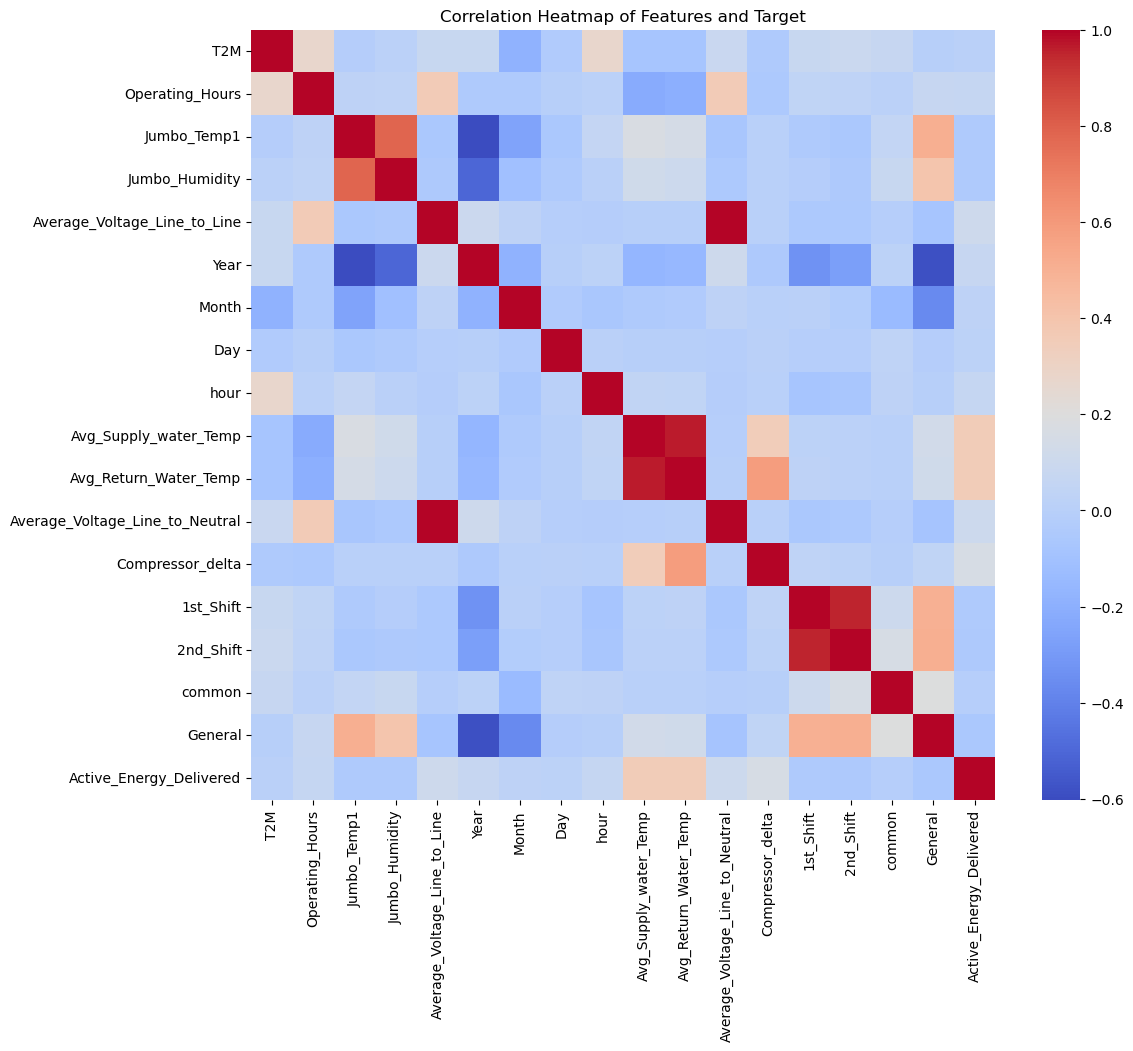


--- Objectives 1, 2 & 5: Training, Evaluation, and Prediction ---
Training Random Forest on all 17355 training samples...
Calculating evaluation metrics...
--- Global Model Metrics ---
  Train: RMSE=4.60, MSE=21.19, R²=0.95
  Test:  RMSE=9.29, MSE=86.29, R²=0.89
  OOB Score (Out-of-Bag): 0.9202

--- Objective 5: Predictions for Recent Data (Test Set) ---
Sample of predictions vs. actuals for the test period:
                     Name     T2M  Operating_Hours  Actual_Power_Consumption  \
17355  HVAC.PrimaryPump_2  19.375         0.004444                     0.030   
17356  HVAC.PrimaryPump_2  20.325         0.703889                     5.217   
17357  HVAC.SecondaryPump  20.325         0.684444                    12.237   
17358      HVAC.Chiller_3  20.325         0.656389                    97.200   
17359  HVAC.PrimaryPump_2  20.850         1.004722                     7.432   

       Jumbo_Temp1  Jumbo_Humidity  Average_Voltage_Line_to_Line  Year  Month  \
17355          0.0       

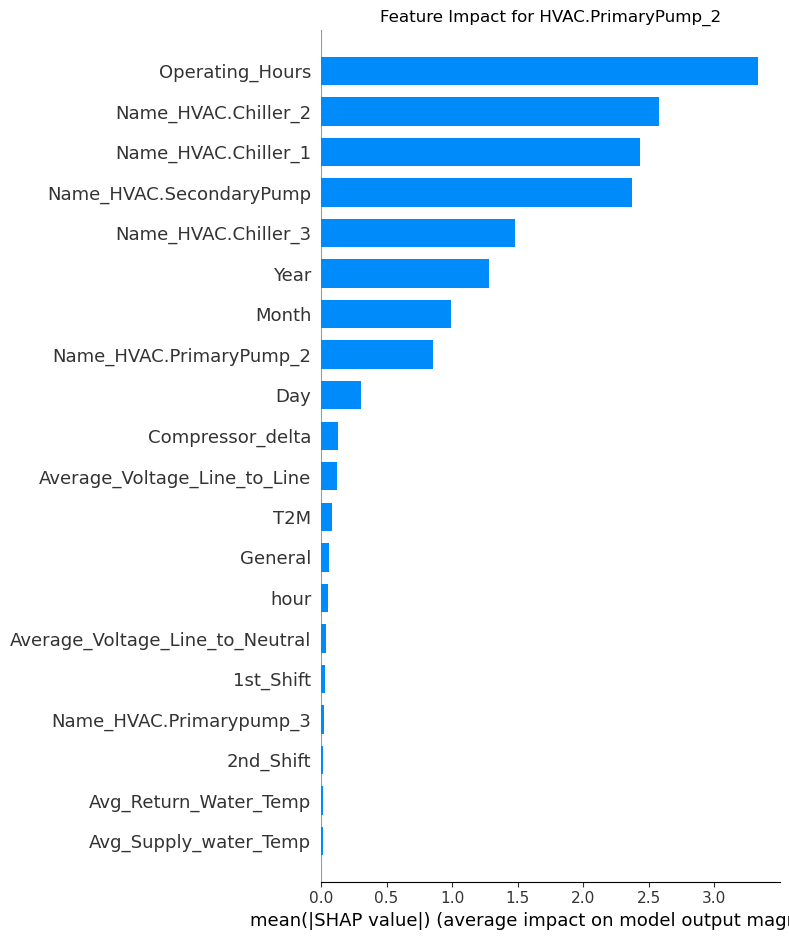


--- SHAP Summary for: HVAC.SecondaryPump ---


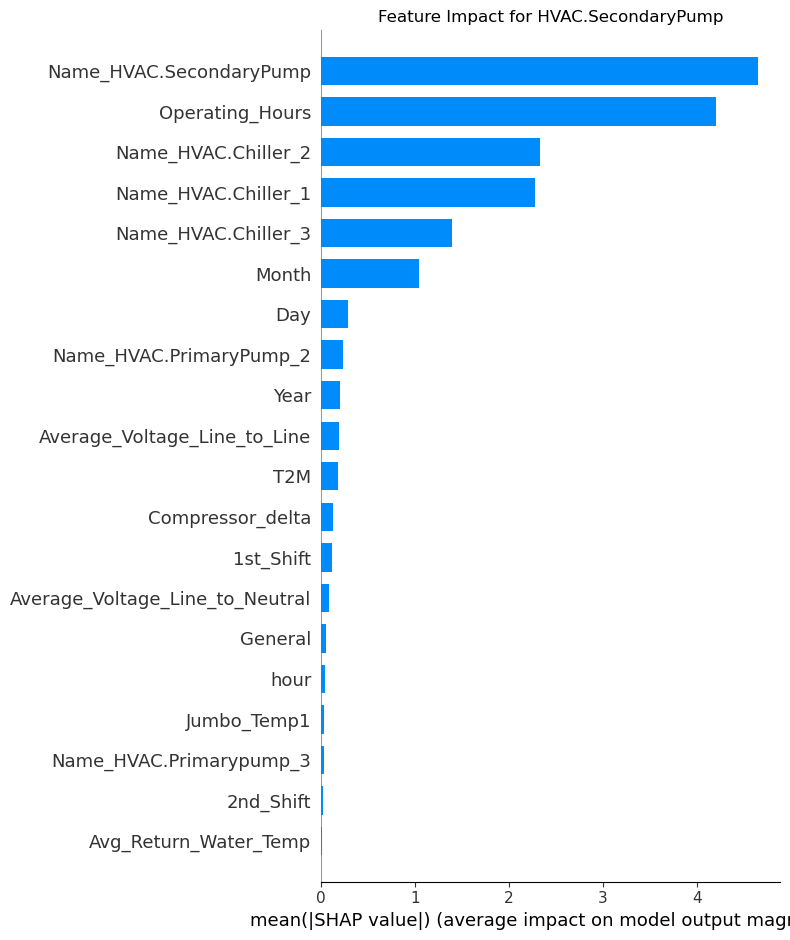


--- SHAP Summary for: HVAC.Chiller_3 ---


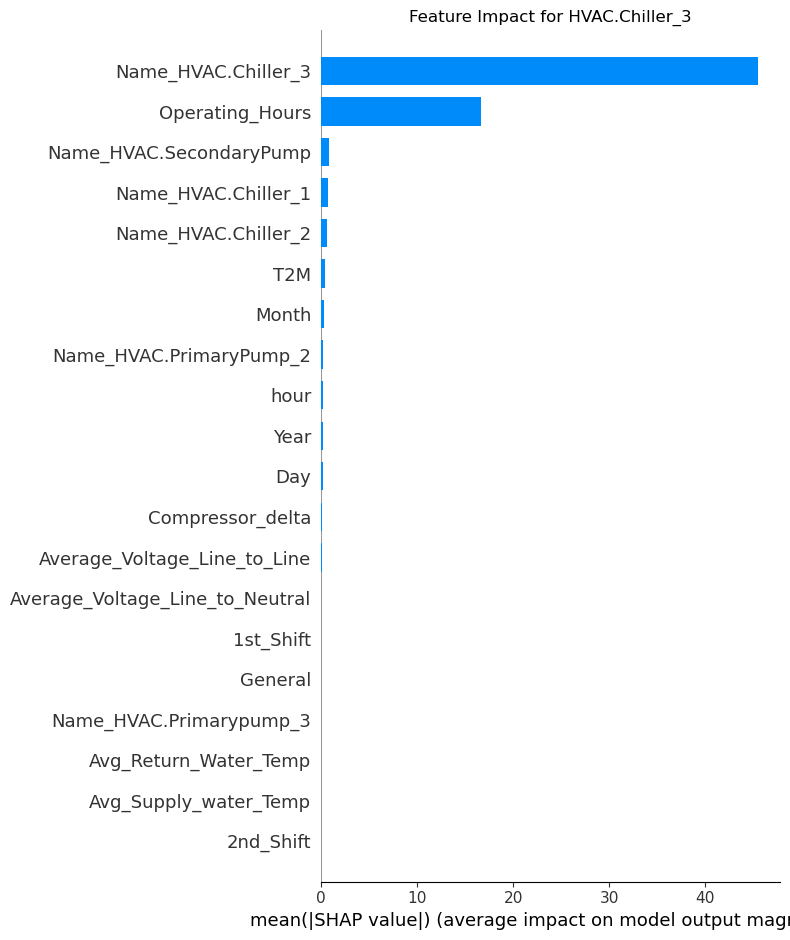


--- SHAP Summary for: HVAC.PrimaryPump_1 ---


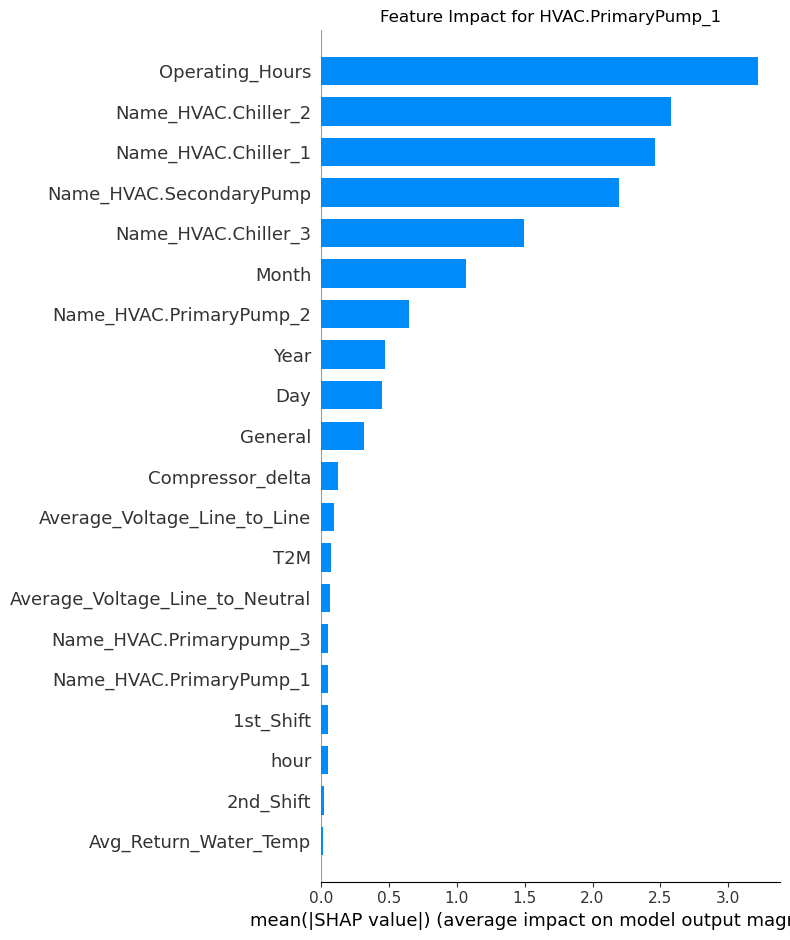


--- SHAP Summary for: HVAC.Chiller_1 ---


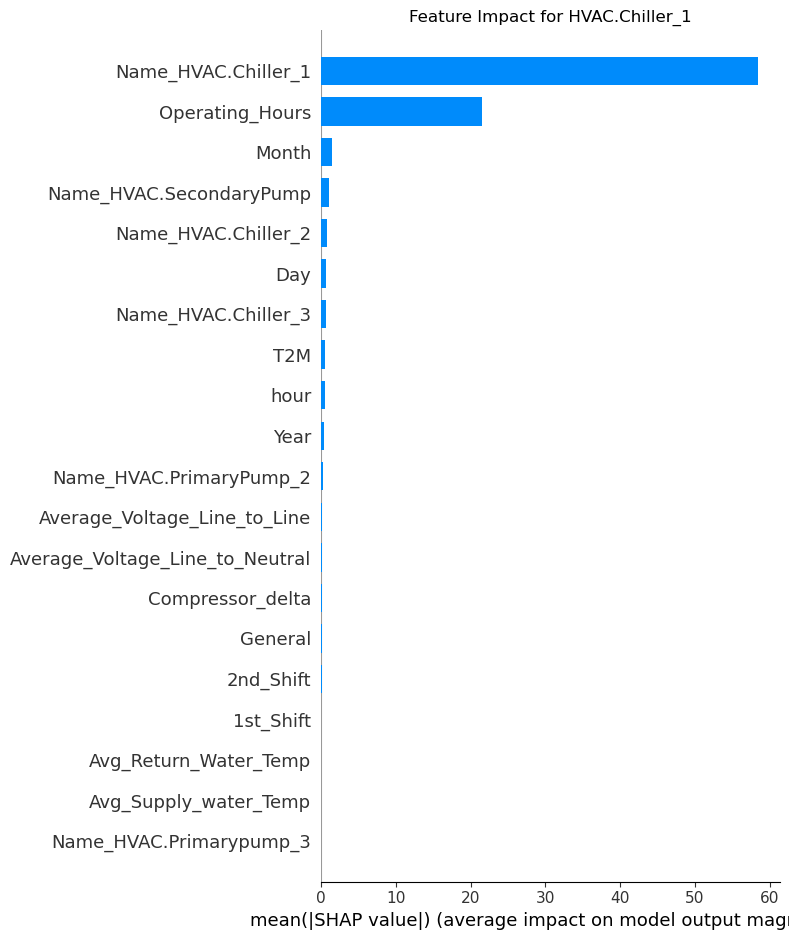


--- SHAP Summary for: HVAC.Chiller_2 ---


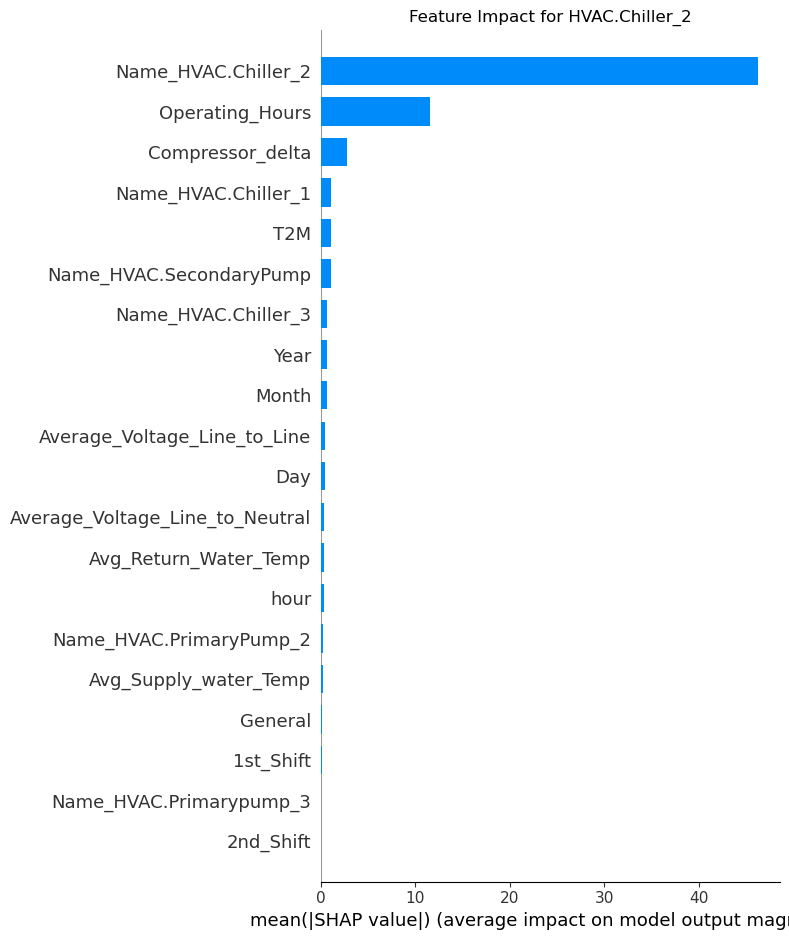


--- SHAP Summary for: HVAC.Primarypump_3 ---


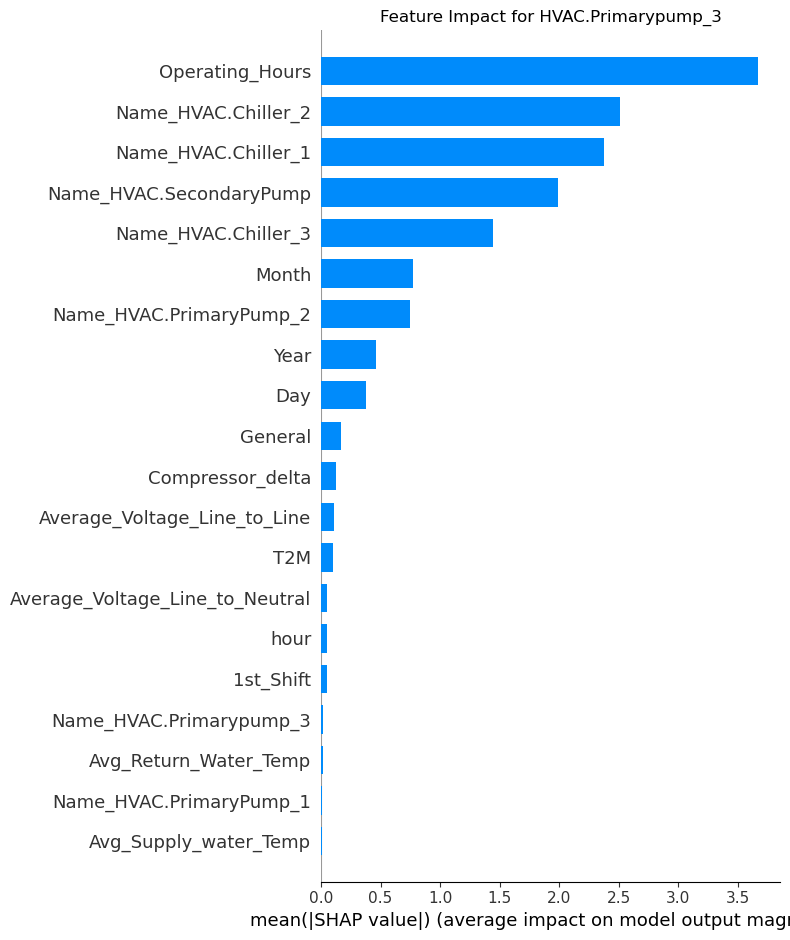


--- Creating Detailed Output File ---
Calculating top 3 impactful features for each prediction...
Matching feature names to their actual values...
Full results dataframe is now created.
Sample of detailed results:
                     Name     T2M  Operating_Hours  Actual_Power_Consumption  \
17355  HVAC.PrimaryPump_2  19.375         0.004444                     0.030   
17356  HVAC.PrimaryPump_2  20.325         0.703889                     5.217   
17357  HVAC.SecondaryPump  20.325         0.684444                    12.237   
17358      HVAC.Chiller_3  20.325         0.656389                    97.200   
17359  HVAC.PrimaryPump_2  20.850         1.004722                     7.432   

       Jumbo_Temp1  Jumbo_Humidity  Average_Voltage_Line_to_Line  Year  Month  \
17355          0.0             0.0                   1653.457825    25      9   
17356          0.0             0.0                   1659.236572    25      9   
17357          0.0             0.0                   1662.022

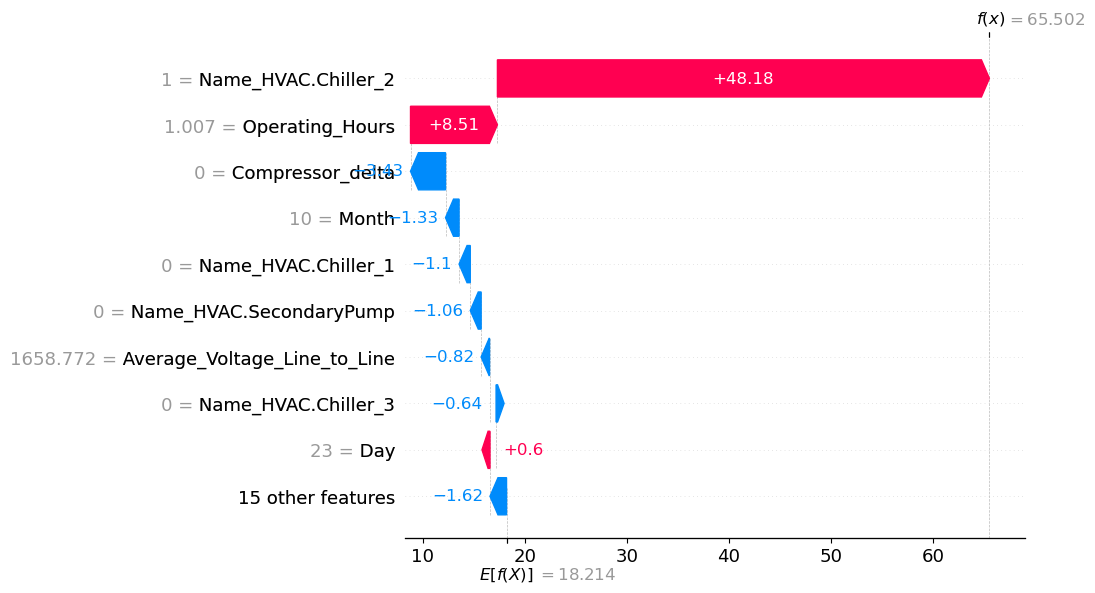


SHAP Summary Plot for *all* high-deviation instances:
This shows which features are most responsible for large errors *overall*.


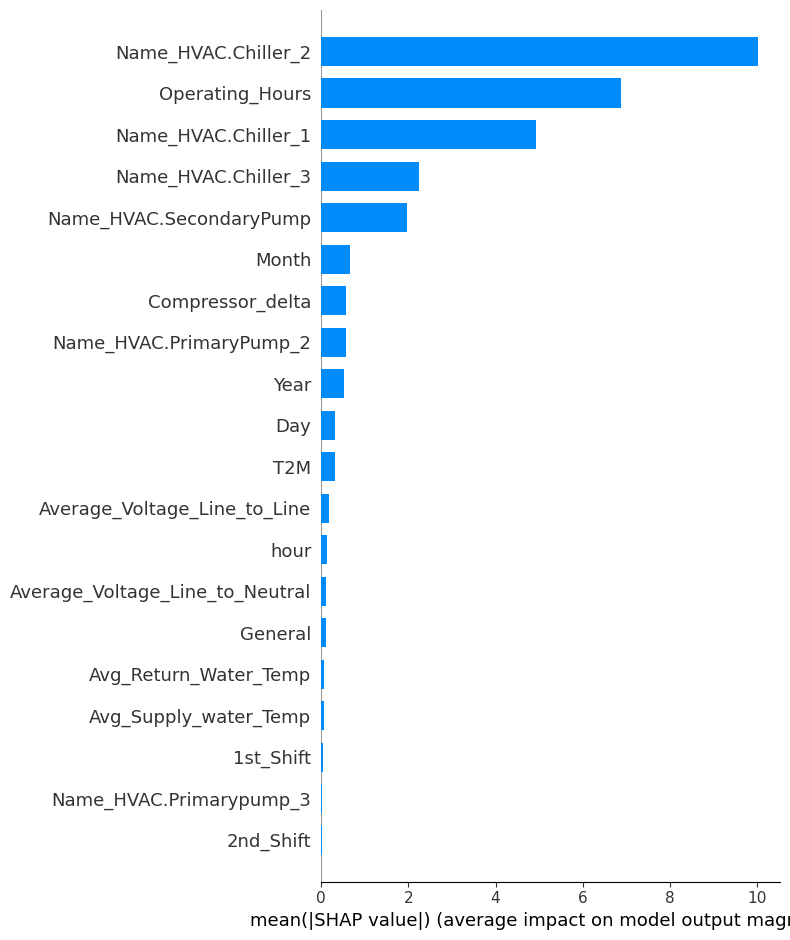


--- Model Building and Analysis Complete ---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Model and metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# --- Configuration ---
DATA_FILE_PATH = "E:/HVAC/preprocessed_data.xlsx"  # <-- Your data file

# Define your target and features
TARGET_VARIABLE = 'Active_Energy_Delivered'

NUMERICAL_FEATURES = [
    'T2M', 'Operating_Hours', 'Jumbo_Temp1', 'Jumbo_Humidity',
    'Average_Voltage_Line_to_Line', 'Year', 'Month', 'Day', 'hour',
    'Avg_Supply_water_Temp', 'Avg_Return_Water_Temp',
    'Average_Voltage_Line_to_Neutral', 'Compressor_delta',
    '1st_Shift', '2nd_Shift', 'common', 'General'
]
CATEGORICAL_FEATURES = ['Name']

# --- 1. Load and Prepare Data ---

print("Loading and preparing data from single file...")
try:
    df = pd.read_excel(DATA_FILE_PATH)
    df = df.fillna(0)
except FileNotFoundError:
    print(f"Error: Data file not found at {DATA_FILE_PATH}")
    # Create a dummy dataframe for demonstration purposes if file not found
    dates = pd.date_range(start='2023-01-01', end='2024-05-27', freq='h')
    df = pd.DataFrame(index=dates)
    df['Date'] = df.index.date
    df['hour'] = df.index.hour
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['Year'] = df.index.year
    df['Name'] = np.random.choice(['Chilling1', 'Chilling2', 'Chilling3'], size=len(df))
    df['Active_Energy_Delivered'] = np.random.rand(len(df)) * 100 + np.sin(df['hour'] * np.pi / 12) * 20 + 50
    for col in NUMERICAL_FEATURES:
        if col not in df.columns:
            df[col] = np.random.rand(len(df))
    print("Loaded dummy data for demonstration.")

# Ensure 'Date' is a datetime object for correct splitting
df['Date'] = pd.to_datetime(df['Date'])

# Sort data by time
df = df.sort_values(by=['Date', 'hour']).reset_index(drop=True)

# --- 2. Split Data (Train vs. Test) ---
today = df['Date'].max()
split_date = today - pd.Timedelta(days=30)
train_df = df[df['Date'] < split_date].copy()
test_df = df[df['Date'] >= split_date].copy()

print(f"Full dataset shape: {df.shape}")
print(f"Using data up to {today.date()} as 'today'.")
print(f"Training data shape: {train_df.shape} (Data before {split_date.date()})")
print(f"Test data shape: {test_df.shape} (Data from {split_date.date()} onwards)")

# --- 3. Feature Engineering: One-Hot Encoding 'Name' ---
print("\nApplying One-Hot Encoding to 'Name'...")
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(train_df[CATEGORICAL_FEATURES])
encoded_feature_names = ohe.get_feature_names_out(CATEGORICAL_FEATURES)
print(f"New encoded features: {list(encoded_feature_names)}")

train_encoded_features = ohe.transform(train_df[CATEGORICAL_FEATURES])
test_encoded_features = ohe.transform(test_df[CATEGORICAL_FEATURES])

train_encoded_df = pd.DataFrame(train_encoded_features, columns=encoded_feature_names, index=train_df.index)
test_encoded_df = pd.DataFrame(test_encoded_features, columns=encoded_feature_names, index=test_df.index)

X_train = pd.concat([train_df[NUMERICAL_FEATURES], train_encoded_df], axis=1)
X_test = pd.concat([test_df[NUMERICAL_FEATURES], test_encoded_df], axis=1)

y_train = train_df[TARGET_VARIABLE]
y_test = test_df[TARGET_VARIABLE]

ALL_FEATURES = NUMERICAL_FEATURES + list(encoded_feature_names)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# --- 4. Objective 4: Correlation Matrix ---
print("\n--- Objective 4: Correlation Analysis (on Training Data) ---")
numerical_data = train_df[NUMERICAL_FEATURES + [TARGET_VARIABLE]]
corr_matrix = numerical_data.corr()
target_corr = corr_matrix[TARGET_VARIABLE].sort_values(ascending=False)
print(f"Correlation with '{TARGET_VARIABLE}':\n{target_corr.head(10)}")

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features and Target')
plt.show()

# --- 5. Objectives 1, 2 & 5: Model Training, Evaluation, and Prediction ---
print("\n--- Objectives 1, 2 & 5: Training, Evaluation, and Prediction ---")
print(f"Training Random Forest on all {X_train.shape[0]} training samples...")
# Using the regularized model (min_samples_leaf=10)
rf_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=42, n_jobs=-1, oob_score=True)
rf_model.fit(X_train, y_train)

print("Calculating evaluation metrics...")
y_train_pred = rf_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

y_test_pred = rf_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"--- Global Model Metrics ---")
print(f"  Train: RMSE={train_rmse:.2f}, MSE={train_mse:.2f}, R²={train_r2:.2f}")
print(f"  Test:  RMSE={test_rmse:.2f}, MSE={test_mse:.2f}, R²={test_r2:.2f}")
print(f"  OOB Score (Out-of-Bag): {rf_model.oob_score_:.4f}")

# --- Create final results dataframe for the test period (Objective 5) ---
print("\n--- Objective 5: Predictions for Recent Data (Test Set) ---")
results_df = test_df.copy()
results_df = results_df.rename(columns={TARGET_VARIABLE: 'Actual_Power_Consumption'})
results_df['Predicted_Power_Consumption'] = y_test_pred
print("Sample of predictions vs. actuals for the test period:")
print(results_df.head())

# --- 6. Objective 3: Feature Importance (Global and Per-Machine) ---
print("\n--- Objective 3: Feature Importance ---")
print("Calculating Global Feature Importances...")
global_importances = rf_model.feature_importances_
global_importance_df = pd.DataFrame({
    'Feature': ALL_FEATURES,
    'Importance': global_importances
}).sort_values(by='Importance', ascending=False)
print(f"Top 10 Global Features:\n{global_importance_df.head(10)}")

print("\nCalculating Per-Machine Feature Importances using SHAP...")
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
shap_df = pd.DataFrame(shap_values, columns=ALL_FEATURES, index=X_test.index)
X_test_with_machine = X_test.join(test_df['Name'])

for machine in test_df['Name'].unique():
    print(f"\n--- SHAP Summary for: {machine} ---")
    machine_indices = X_test_with_machine[X_test_with_machine['Name'] == machine].index
    machine_shap_values = shap_df.loc[machine_indices].values
    machine_X_test = X_test.loc[machine_indices]
    if machine_X_test.empty:
        print("No test data for this machine.")
        continue
    plt.title(f"Feature Impact for {machine}")
    shap.summary_plot(machine_shap_values, machine_X_test, plot_type="bar", show=True)


# --- 7. NEW: Create Detailed Output with Feature Impacts ---
print("\n--- Creating Detailed Output File ---")

# Add error calculations to our results_df
results_df['Error'] = results_df['Actual_Power_Consumption'] - results_df['Predicted_Power_Consumption']
results_df['Perc_Error'] = 100 * (results_df['Error'] / results_df['Actual_Power_Consumption']).replace([np.inf, -np.inf, np.nan], 0)

print("Calculating top 3 impactful features for each prediction...")
# We already have shap_df from Step 6.
# Create a dataframe of absolute shap values
abs_shap_df = shap_df.abs()

# Get the column names (features) for the 3 largest values in each row
top_3_features_series = abs_shap_df.apply(lambda row: row.nlargest(3).index.tolist(), axis=1)

# Split this Series into three new columns in results_df
results_df['Impact_Feature_1_Name'] = top_3_features_series.str[0]
results_df['Impact_Feature_2_Name'] = top_3_features_series.str[1]
results_df['Impact_Feature_3_Name'] = top_3_features_series.str[2]

# Now, get the actual values for these features from X_test
print("Matching feature names to their actual values...")
results_df['Impact_Feature_1_Value'] = results_df.apply(
    lambda row: X_test.loc[row.name, row['Impact_Feature_1_Name']], axis=1
)
results_df['Impact_Feature_2_Value'] = results_df.apply(
    lambda row: X_test.loc[row.name, row['Impact_Feature_2_Name']], axis=1
)
results_df['Impact_Feature_3_Value'] = results_df.apply(
    lambda row: X_test.loc[row.name, row['Impact_Feature_3_Name']], axis=1
)

print("Full results dataframe is now created.")
print("Sample of detailed results:")
print(results_df.head())

# --- 8. NEW: Save Final Output and Analyze Deviations ---
# This is the output you requested
output_file_name = "E:/HVAC/hvac_prediction_results_with_features.xlsx"
try:
    results_df.to_excel(output_file_name, index=False)
    print(f"\nSuccessfully saved detailed results to: {output_file_name}")
except Exception as e:
    print(f"\nError saving to Excel: {e}")
    print("Saving as CSV instead...")
    output_file_name_csv = "E:/HVAC/hvac_prediction_results_with_features.xlsx"
    results_df.to_csv(output_file_name_csv, index=False)
    print(f"Successfully saved detailed results to: {output_file_name_csv}")

# --- Objective 6 (Modified): Analyze Deviations from the detailed results ---
print("\n--- Objective 6: Analyzing Large Deviations (>20%) ---")

# Find instances with > 20% deviation
deviation_rows = results_df[abs(results_df['Perc_Error']) > 20]

if deviation_rows.empty:
    print("No significant deviations (>20%) found in the test set. Model is performing well!")
else:
    print(f"Found {len(deviation_rows)} instances with >20% error.")
    
    # Print the requested columns for the deviation rows
    print("\n--- Details for High-Deviation Rows (from the saved file) ---")
    columns_to_show = [
        'Date', 'hour', 'Name', 'Actual_Power_Consumption', 'Predicted_Power_Consumption',
        'Error', 'Perc_Error', 'Impact_Feature_1_Name', 'Impact_Feature_1_Value',
        'Impact_Feature_2_Name', 'Impact_Feature_2_Value', 'Impact_Feature_3_Name', 'Impact_Feature_3_Value'
    ]
    # Set display options to see all columns
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(deviation_rows[columns_to_show])
    
    # Continue with SHAP plot for the worst one
    print("\nAnalyzing the single *worst* deviation with SHAP plot...")
    
    worst_deviation_idx_loc = deviation_rows['Error'].abs().idxmax()
    worst_deviation_int_loc = X_test.index.get_loc(worst_deviation_idx_loc)
    
    print(f"\n--- Explaining Instance (Index: {worst_deviation_idx_loc}) ---")
    print(f"  Date: {results_df.loc[worst_deviation_idx_loc, 'Date'].date()}")
    print(f"  Hour: {results_df.loc[worst_deviation_idx_loc, 'hour']}")
    print(f"  Machine: {results_df.loc[worst_deviation_idx_loc, 'Name']}")
    print(f"  Actual Power: {results_df.loc[worst_deviation_idx_loc, 'Actual_Power_Consumption']:.2f}")
    print(f"  Predicted Power: {results_df.loc[worst_deviation_idx_loc, 'Predicted_Power_Consumption']:.2f}")
    print(f"  Error: {results_df.loc[worst_deviation_idx_loc, 'Error']:.2f} ({results_df.loc[worst_deviation_idx_loc, 'Perc_Error']:.1f}%)")
    print(f"  Top 3 Drivers: ")
    print(f"    1. {results_df.loc[worst_deviation_idx_loc, 'Impact_Feature_1_Name']} = {results_df.loc[worst_deviation_idx_loc, 'Impact_Feature_1_Value']}")
    print(f"    2. {results_df.loc[worst_deviation_idx_loc, 'Impact_Feature_2_Name']} = {results_df.loc[worst_deviation_idx_loc, 'Impact_Feature_2_Value']}")
    print(f"    3. {results_df.loc[worst_deviation_idx_loc, 'Impact_Feature_3_Name']} = {results_df.loc[worst_deviation_idx_loc, 'Impact_Feature_3_Value']}")


    print("\nThis SHAP plot shows *why* the model made its prediction.")
    print("Features pushing the prediction HIGHER are in red.")
    print("Features pushing the prediction LOWER are in blue.")
    
    # shap.initjs() # Uncomment if running in a Jupyter Notebook
    
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[worst_deviation_int_loc],
        base_values=explainer.expected_value,
        data=X_test.iloc[worst_deviation_int_loc],
        feature_names=ALL_FEATURES
    ))
    
    # Summary plot for ALL deviations
    deviation_indices = X_test.index.isin(deviation_rows.index)
    deviation_shap_values = shap_values[deviation_indices]
    deviation_X_test = X_test[deviation_indices]

    print("\nSHAP Summary Plot for *all* high-deviation instances:")
    print("This shows which features are most responsible for large errors *overall*.")
    shap.summary_plot(deviation_shap_values, deviation_X_test, plot_type="bar")
    
print("\n--- Model Building and Analysis Complete ---")

In [3]:
deviation_rows.to_excel("E:/HVAC/Deviation_rows.xlsx")